# QuickGuide for Rtings

[프로젝트 페이지: Research-on-the-TV-market](https://github.com/xikest/research-market-tv)

## Env setting: Install Colab selenium & crome driver

In [1]:
!pip install -U pandas openpyxl tqdm
!pip install -U requests selenium beautifulsoup4 
!pip install -U wordcloud nltk 
!pip install -U scikit-learn openai 
!pip install -U matplotlib seaborn
!pip install -U getmodelspec

   ---------------------------------------- 0.0/220.3 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/220.3 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 220.3/220.3 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.2.4
    Uninstalling openai-1.2.4:
      Successfully uninstalled openai-1.2.4
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.6 MB 1.4 MB/s eta 0:00:06
   --- ------------------------------------ 0.6/7.6 MB 7.4 MB/s eta 0:00:01
   ------------------ --------------------- 3.4/7.6 MB 27.4 MB/s eta 0:00:01
   -------------------------------- ------- 6.2/7.6 MB 39.7 MB/s eta 0:00:01
   ---------------------------------------  7.6/7.6 MB 40.8 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 34.9 MB/s eta 0:00:00
  Attempting uninsta

In [2]:
from market_research.tools.installer import Installer
Installer.install_chrome_and_driver()

windows


{'chrome_path': 'C:\\Users\\taest\\Documents\\github\\research-market-tv\\chrome',
 'driver_path': 'C:\\Users\\taest\\Documents\\github\\research-market-tv\\chromedriver'}

## Env. 세팅

In [1]:
import platform
from datetime import date
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import files
from market_research import Rtings
from market_research.tools import FileManager

### 분석 폴더 생성
- `input_data`: 검색할 데이터 폴더
- `results`: 검색된 데이터 폴더

In [11]:
intput_folder = Path("input_urls")  # 폴더 이름을 지정
if not intput_folder.exists():
    intput_folder.mkdir(parents=True)

output_folder = Path('results')  
if not output_folder.exists():
  output_folder.mkdir(parents=True, exist_ok=True)

 # 저장할 데이터 경로
file_name = f"rtings{date.today().strftime('%Y-%m-%d')}.xlsx"
output_file_name = output_folder/file_name

## 준비

- 엑셀 파일의 column 명은 `urls.xlsx`으로 하여 `input_urls`폴더에 넣어주세요

In [15]:
urls=["https://www.rtings.com/tv/reviews/sony/a95l-oled",
      "https://www.rtings.com/tv/reviews/lg/g3-oled",
      "https://www.rtings.com/tv/reviews/sony/a80l-a80cl-oled",
      "https://www.rtings.com/tv/reviews/lg/c3-oled",
      "https://www.rtings.com/tv/reviews/sony/x95l",
      "https://www.rtings.com/tv/reviews/sony/x93l-x93cl",
      "https://www.rtings.com/tv/reviews/sony/x90l-x90cl"]

In [ ]:
model_list = ["x95l","a95l","A80","g3","c3"]

In [ ]:
rtings = Rtings(webdriver_path = webdriver_path, browser_path=browser_path, enable_headless=enable_headless)
urls=rtings.search_and_extract_url(search_query=model) for model in model_list]
urls

In [16]:
# 분석할 엑셀 파일이 있는 폴더 경로
if not urls:
    file_list = intput_folder.glob('*')
    excel_files = [file for file in file_list if file.suffix in {'.xlsx', '.xls'}]
    
    for excel_file in excel_files:
        df = pd.read_excel(excel_file)
        urls.extend(df["urls"])
print(urls)

['https://www.rtings.com/tv/reviews/sony/a95l-oled', 'https://www.rtings.com/tv/reviews/lg/g3-oled', 'https://www.rtings.com/tv/reviews/sony/a80l-a80cl-oled', 'https://www.rtings.com/tv/reviews/lg/c3-oled', 'https://www.rtings.com/tv/reviews/sony/x95l', 'https://www.rtings.com/tv/reviews/sony/x93l-x93cl', 'https://www.rtings.com/tv/reviews/sony/x90l-x90cl']


In [14]:
current_os = platform.system()
if current_os == "Linux":
    webdriver_path = "/content/chromedriver/chromedriver"
    browser_path = "/content/chrome/chrome"
elif current_os == "Windows":
    webdriver_path = "./chromedriver/chromedriver.exe"
    browser_path = "./chrome/chrome.exe"

enable_headless = True

## gathering data

In [17]:
score_df = pd.DataFrame()
measurement_df = pd.DataFrame()
comments_df = pd.DataFrame()

rtings = Rtings(webdriver_path = webdriver_path, browser_path=browser_path, enable_headless=enable_headless)

for url in urls:
    maker = url.split("/")[-2]
    model = url.split("/")[-1]
    


    df= rtings.get_score(url,format_df=True)
    score_df = pd.concat([score_df,df], axis=0)

    # 저장할 데이터 경로
    df= rtings.get_measurement_reuslts(url)
    measurement_df = pd.concat([measurement_df,df], axis=0)

    comments_df = rtings.get_commetns(url, format_df=True)
    comments_df = pd.concat([comments_df,df], axis=0)
    
FileManager.df_to_excel(score_df, file_name=output_file_name, sheet_name="scores", mode='w')    
FileManager.df_to_excel(measurement_df, file_name=output_file_name, sheet_name="measurement", mode='a')
FileManager.df_to_excel(comments_df, file_name=output_file_name, sheet_name="comments", mode='a')

connecting to https://www.rtings.com/tv/reviews/sony/a95l-oled for score
connecting to https://www.rtings.com/tv/reviews/sony/a95l-oled for detail
connecting to https://www.rtings.com/tv/reviews/sony/a95l-oled for comments
connecting to https://www.rtings.com/tv/reviews/lg/g3-oled for score
connecting to https://www.rtings.com/tv/reviews/lg/g3-oled for detail
connecting to https://www.rtings.com/tv/reviews/lg/g3-oled for comments
connecting to https://www.rtings.com/tv/reviews/sony/a80l-a80cl-oled for score
connecting to https://www.rtings.com/tv/reviews/sony/a80l-a80cl-oled for detail
connecting to https://www.rtings.com/tv/reviews/sony/a80l-a80cl-oled for comments
connecting to https://www.rtings.com/tv/reviews/lg/c3-oled for score
connecting to https://www.rtings.com/tv/reviews/lg/c3-oled for detail
connecting to https://www.rtings.com/tv/reviews/lg/c3-oled for comments
connecting to https://www.rtings.com/tv/reviews/sony/x95l for score
connecting to https://www.rtings.com/tv/review

In [62]:
# file_path= "results/rtings2023-11-18.xlsx"
# measurement_df = pd.read_excel(file_path, sheet_name="measurement")
# score_df = pd.read_excel(file_path, sheet_name="scores")

## plot

- seaborn plot color map: https://seaborn.pydata.org/tutorial/color_palettes.html  
- plotly plot color map: https://plotly.com/python/builtin-colorscales/

In [42]:
import pandas as pd

def _retrim(ds: pd.Series, mark: str = ","):
    return ds.str.replace(mark, "")

def get_data_detail(df: pd.DataFrame, column: str=None, mode="normal"):
    """
    mode="brightness"
    """
    data_df = df
    if column is not None:
        data_df = df[df["header"] == column]
    
    # Clean and convert the "result_value" column
    trim_marks = ["cd/m²", ",", "%","°","K","ms","Hz","dB"]
    for trim_mark in trim_marks:
        try:
            data_df.loc[:,"result_value"] = _retrim(data_df["result_value"], trim_mark)
        except:
            pass

    data_df.loc[:,"result_value"] = data_df["result_value"].str.strip().astype(float)
    data_df = data_df.sort_values(["maker", "product", "label"], ascending=False)
    data_df = data_df.pivot(index=["maker", "product"], columns="label", values='result_value')
    data_df.columns = data_df.columns.map(lambda x: str(x))
    data_df = data_df.reset_index()
    data_df.loc[:,'model'] = data_df['maker'] + '_' + data_df['product']
    data_df = data_df.drop(["maker", "product"], axis=1)
    data_df = data_df.melt(id_vars=['model'], var_name='label', value_name=column)

    if mode == "brightness":
      data_df = _briteness_trim(data_df)

    return data_df


def _briteness_trim(df):
  df_peak = df[df['label'].str.contains("Window") & df['label'].str.contains("Peak")]
  df_peak.loc[:, "label"] = df_peak["label"].map(lambda x: int(x.split("%")[0].split(" ")[-1]))

  df_peak = df_peak.sort_values(["model","label"], ascending=True)
  df_peak["label"]=df_peak.label.map(lambda x: str(x)+"%")
  # hdr_df_peak
  df_peak = df_peak.rename(columns={"label":"APL"})
  return df_peak

In [128]:

def plotsns_facet_bar(df,col_x:str, col_y:str, col_facet:str, col_wrap=5, height=4, facet_yticks:dict|list={}, facet_ylims:dict|tuple={}, show_annot=True):
  color_palette = sns.color_palette("Set2", n_colors=len(set(df[col_x])))

  sns.set(style="whitegrid")
  g = sns.FacetGrid(df, col=col_facet, col_wrap=col_wrap, height=height, sharey=False, sharex=False)
  g.map_dataframe(sns.barplot, x=col_x, y=col_y, hue=col_x, palette=color_palette,)
  g.set_axis_labels(col_x, col_y)


  # for ax in g.axes.flat:
  if facet_yticks:
    if isinstance(facet_yticks,dict):
      for idx, ytick in facet_yticks.items():
        g.axes.flat[int(idx)].yaxis.set_ticks(ytick)
    elif isinstance(facet_yticks,list):
      for ax in g.axes.flat:
        ax.yaxis.set_ticks(facet_yticks)

  if facet_ylims:
    if isinstance(facet_ylims,dict):
      for idx, ylim in facet_ylims.items():
        g.axes.flat[idx].set(ylim=ylim)
    elif isinstance(facet_ylims,tuple):
      for ax in g.axes.flat:
        ax.set(ylim=facet_ylims)


  g.set_xticklabels(rotation=45, horizontalalignment='right')
  g.fig.suptitle(col_y, y=1.05)
  # Annotate bars with data values

  if show_annot:
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        ax.yaxis.set_ticks([])
  sns.despine()
  plt.tight_layout()
  plt.show()



def plot_lines(df,col_x:str, col_y:str,col_color:str=None, title=None, range= [], y_ticks:list=[]):
  if col_color is not None:
    fig = px.line(df, x=col_x, y=col_y, color=col_color, title=title, line_shape='linear',
                color_discrete_sequence=px.colors.qualitative.Vivid)
  else:
    fig = px.line(df, x=col_x, y=col_y, title=title, line_shape='linear',
            color_discrete_sequence=px.colors.qualitative.Vivid)


  fig.update_layout(width=1000, height=500, template='plotly_white', margin=dict(l=10, r=10, b=10, t=40))
  if y_ticks: 
    tickvals = [float(y_tick) for y_tick in y_ticks]
    ticktext = [str(y_tick) for y_tick in y_ticks]
    fig.update_yaxes(tickvals=tickvals, ticktext=ticktext)
  if range:
    fig.update_yaxes(range=range)
  fig.show()

  # template='plotly_dark','ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white'
  sns.despine()


## rtings scores, Heatmap

In [420]:
col_socres = ["maker","product","category","header", "score"]
data_df = measurement_df[col_socres].drop_duplicates().replace("",np.nan).dropna()
data_df["score"] = data_df["score"].map(lambda x:float(x))
data_df["product"] = data_df["product"].map(lambda x: x.replace("-oled",""))
data_df = data_df.pivot(index=["maker","product"], columns=["category","header"], values='score')

In [421]:
col_drop = []
col_drop.extend([ column for column in data_df.columns  if 'Sound Quality' in column[0]])
col_drop.extend([ column for column in data_df.columns  if 'Smart Features' in column[0]])
col_drop.extend([ column for column in data_df.columns  if 'Inputs' in column[0]])
data_df = data_df.drop(col_drop, axis=1)

data_df = data_df.T.reset_index().drop("category",axis=1).set_index("header")

C:\Users\taest\AppData\Local\Temp\ipykernel_1348\3791801365.py:7: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



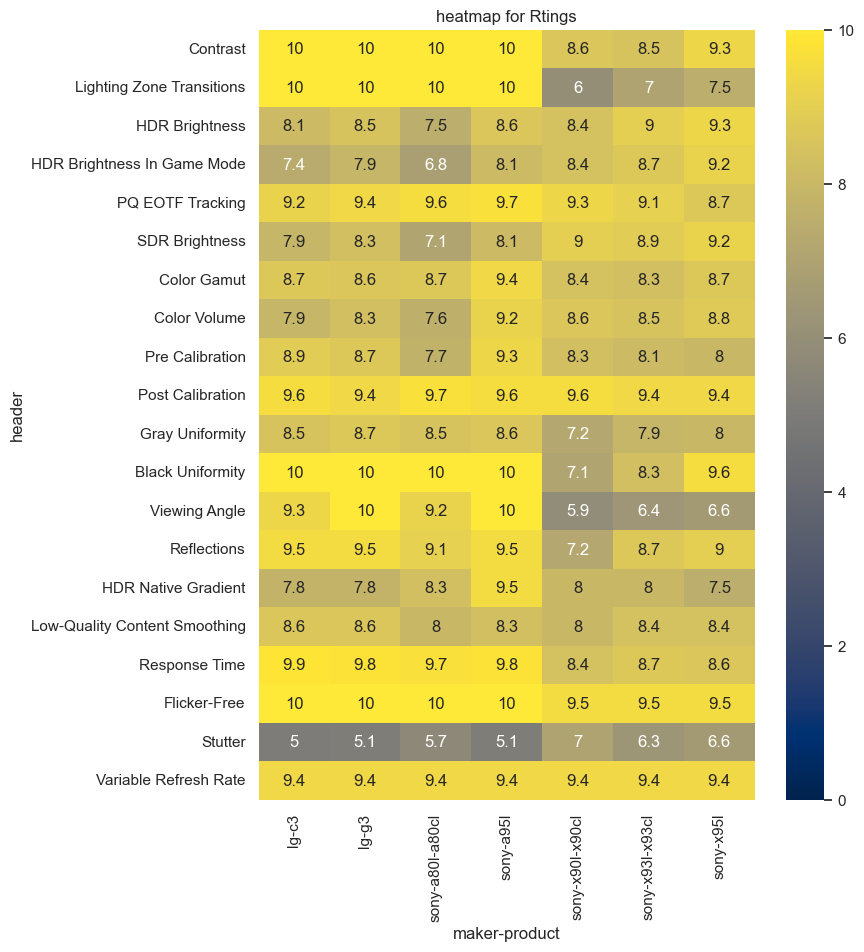

In [422]:
plt.figure(figsize=(8,10))
sns.heatmap(data_df, annot=True, cmap="cividis", cbar=True, vmin=0, vmax=10, yticklabels=data_df.index)
plt.title("heatmap for Rtings")
plt.show()

In [64]:
for target, value in value_dict.items():
    measurement_df.loc[:,"result_value"] = measurement_df.result_value.map(lambda x:str(x))

In [65]:
label_dict= {'1,000 cd/m² DCI P3 Coverage ITP':"DCI",
          '10,000 cd/m² Rec 2020 Coverage ITP':"BT2020",
          'Blue Luminance':"Blue",
          'Cyan Luminance':"Cyan",
          'Green Luminance':"Green",
          'Magenta Luminance':"Magenta",
          'Red Luminance':"Red",
          'White Luminance':"White",
          'Yellow Luminance':"Yellow"}

value_dict = {"N/A":"0", "Inf ":"1000000000"}
for target, label in label_dict.items():
    measurement_df.loc[:,"label"] = measurement_df.label.map(lambda x:x.replace(target, label))
for target, value in value_dict.items():
    measurement_df.loc[:,"result_value"] = measurement_df.result_value.map(lambda x:x.replace(target, value))
measurement_df = measurement_df[~measurement_df.score.isin([""])] # score가 있는 데이터만 사용

In [66]:
set(measurement_df.header)

{'Black Frame Insertion (BFI)',
 'Black Uniformity',
 'Borders',
 'Color Gamut',
 'Color Volume',
 'Contrast',
 'Distortion',
 'Flicker-Free',
 'Frequency Response',
 'Gray Uniformity',
 'HDR Brightness',
 'HDR Brightness In Game Mode',
 'HDR Native Gradient',
 'Input Lag',
 'Interface',
 'Lighting Zone Transitions',
 'Low-Quality Content Smoothing',
 'Misc',
 'PQ EOTF Tracking',
 'Post Calibration',
 'Pre Calibration',
 'Reflections',
 'Response Time',
 'SDR Brightness',
 'Stutter',
 'Thickness',
 'Variable Refresh Rate',
 'Viewing Angle'}

C:\Users\taest\miniconda3\envs\scraper310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


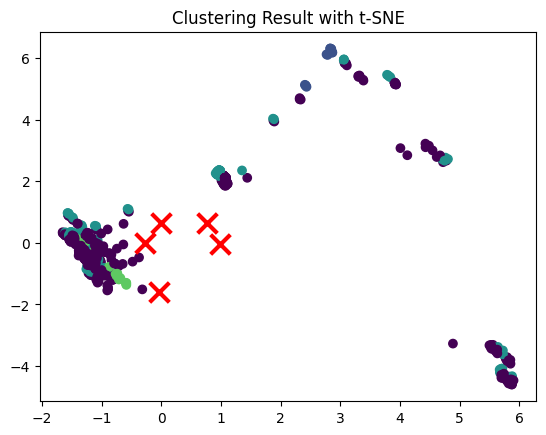

In [51]:
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # 데이터 읽기 및 전처리
# X = pd.get_dummies(measurement_df, drop_first=True)

# # 표준화 (또는 정규화)
# scaler = StandardScaler()  # 또는 MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # 최적의 클러스터 수 찾기
# # optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # 최대 실루엣 점수의 클러스터 수
# # print(f'Optimal Number of Clusters: {optimal_num_clusters}')

# # K-평균 모델 정의 및 학습
# # kmeans = KMeans(n_clusters=optimal_num_clusters)
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(X_scaled)

# # t-SNE를 사용하여 데이터를 2차원으로 축소
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# # 각 데이터 포인트가 속한 클러스터 예측
# labels = kmeans.predict(X_scaled)

# # 결과 시각화
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='red')
# plt.title('Clustering Result with t-SNE')
# plt.show()

## Lighting Zone Transitions

In [413]:
target_col = 'Lighting Zone Transitions'
df = get_data_detail(measurement_df, target_col)

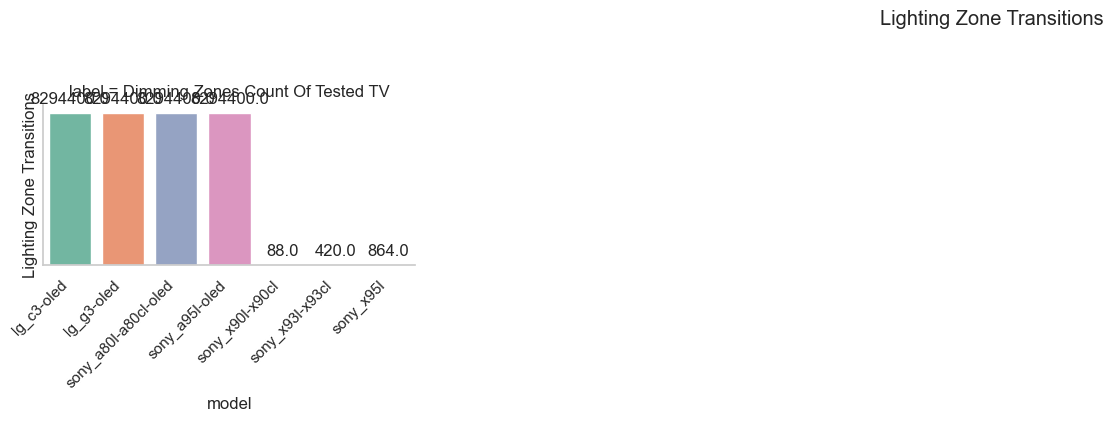

In [417]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")

## HDR Brightness

In [299]:
target_col =  'HDR Brightness'
mode="brightness"
facet_yticks = [200,500,1000,1500]
facet_ylims = (0, 2000)

<Figure size 640x480 with 0 Axes>

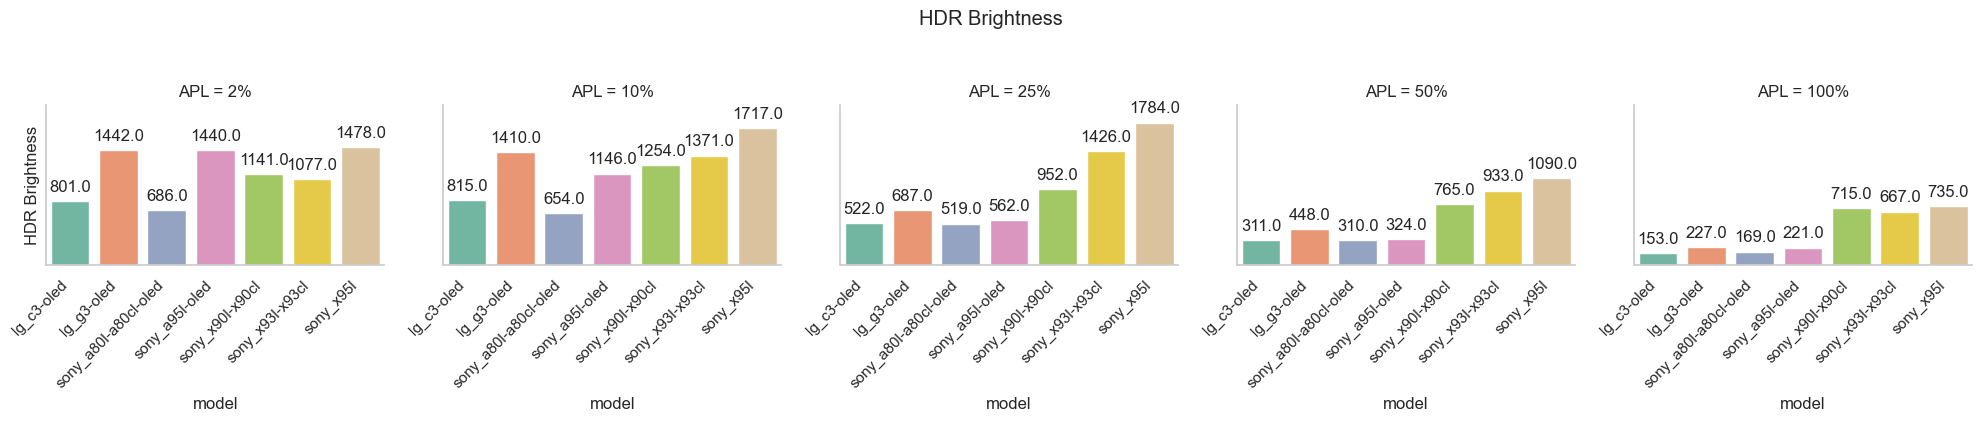

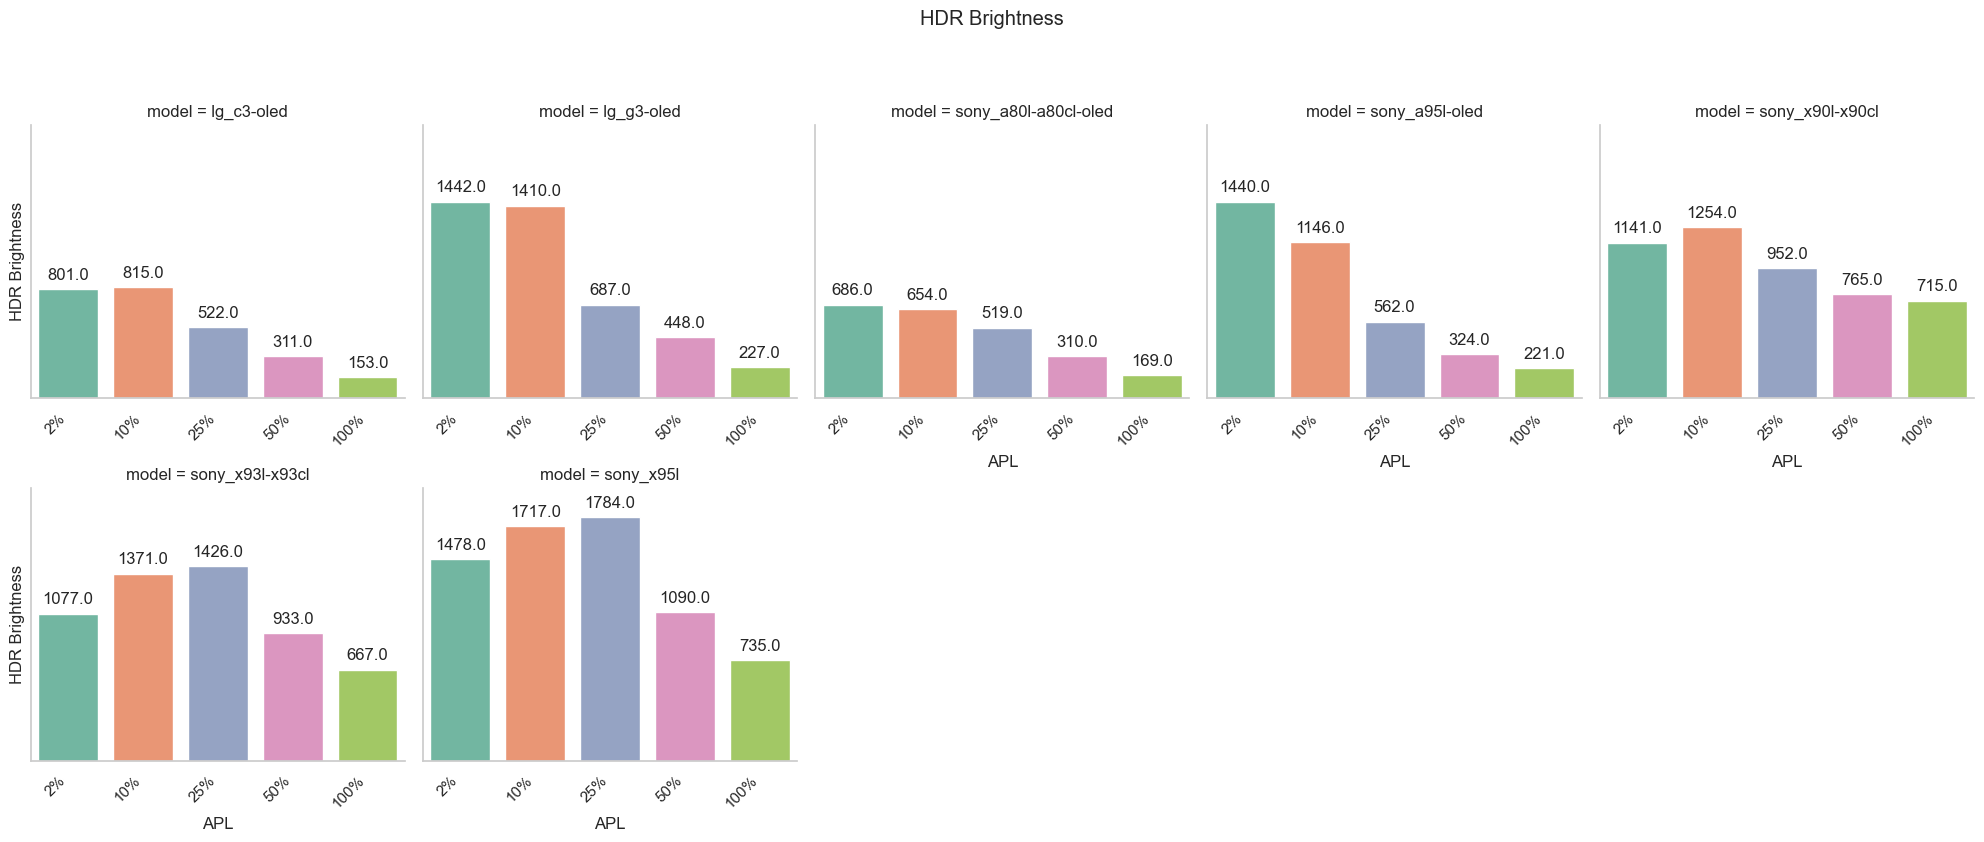

In [300]:
df = get_data_detail(measurement_df, target_col, mode=mode)
plot_lines(df, col_x="APL", col_y=target_col, col_color="model")
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="APL", facet_yticks=facet_yticks, facet_ylims=facet_ylims)
plotsns_facet_bar(df, col_x="APL", col_y=target_col, col_facet="model", facet_yticks=facet_yticks, facet_ylims=facet_ylims)

## HDR Brightness In Game Mod

In [409]:
target_col =  'HDR Brightness In Game Mode'
mode="brightness"
facet_yticks = [200,500,1000,1500]
facet_ylims = (0, 2000)

<Figure size 640x480 with 0 Axes>

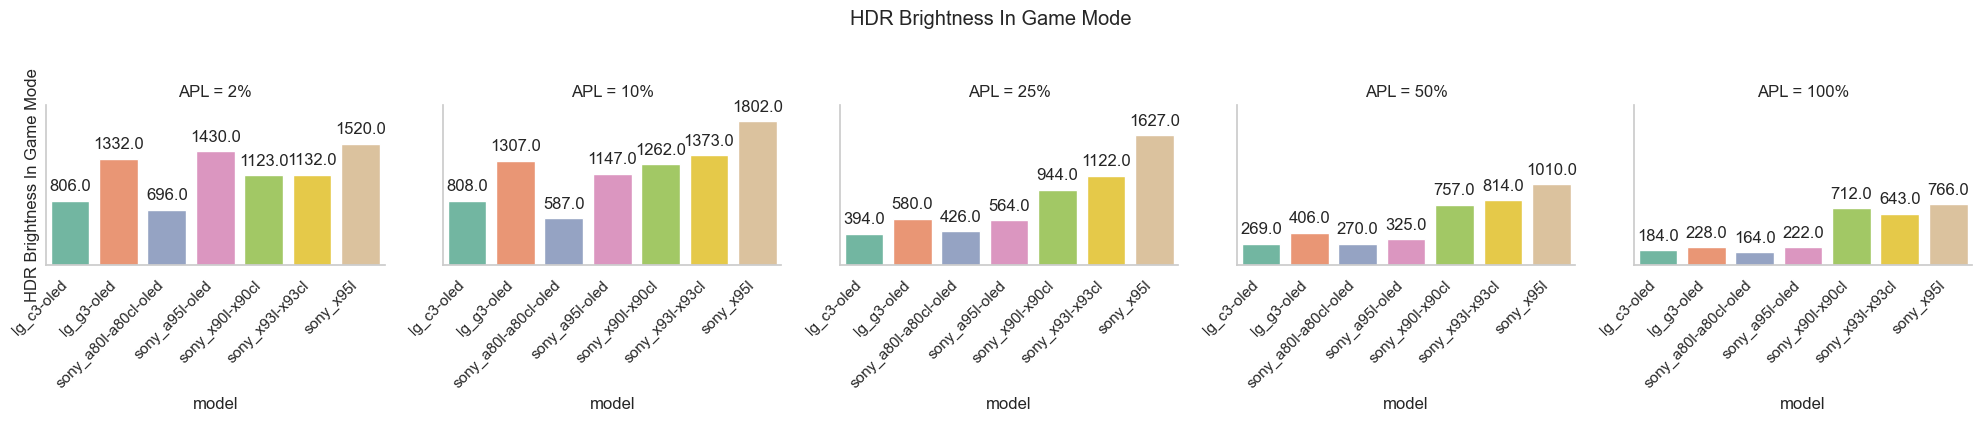

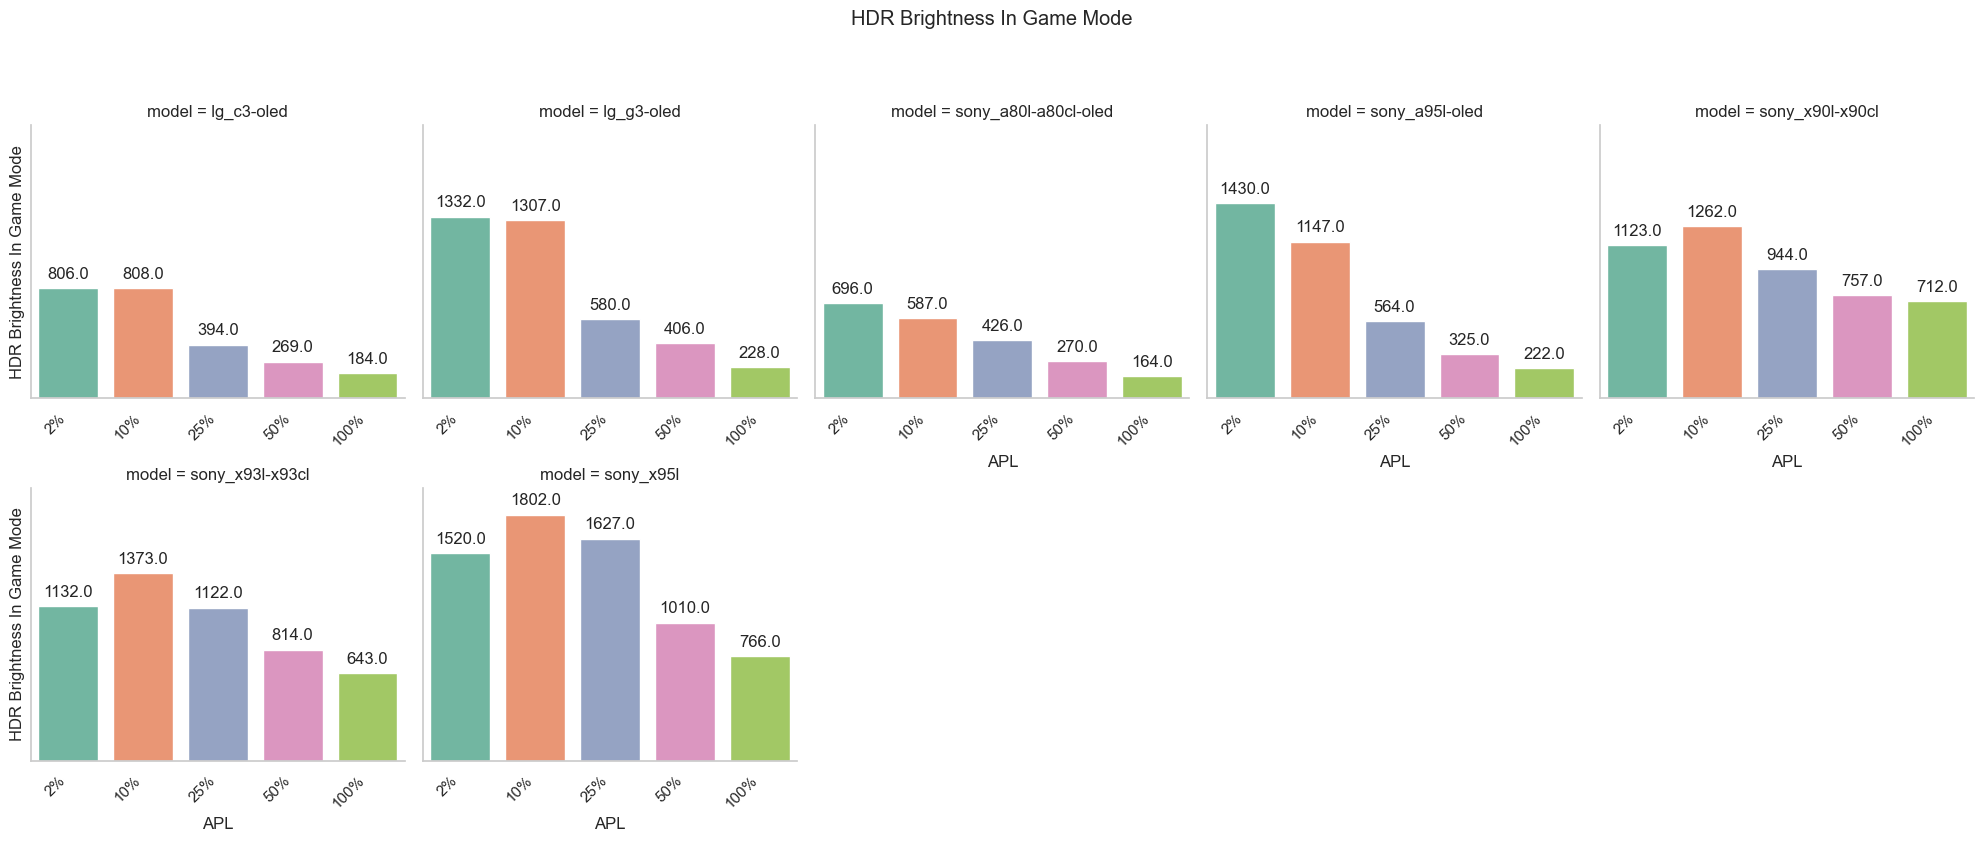

In [410]:
df = get_data_detail(measurement_df, target_col, mode=mode)
plot_lines(df, col_x="APL", col_y=target_col, col_color="model")
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="APL", facet_yticks=facet_yticks, facet_ylims=facet_ylims)
plotsns_facet_bar(df, col_x="APL", col_y=target_col, col_facet="model", facet_yticks=facet_yticks, facet_ylims=facet_ylims)

## SDR Brightness

In [239]:
target_col = 'SDR Brightness'
mode="brightness"
facet_yticks = [200,500,1000,1500]
facet_ylims = (0, 2000)

<Figure size 640x480 with 0 Axes>

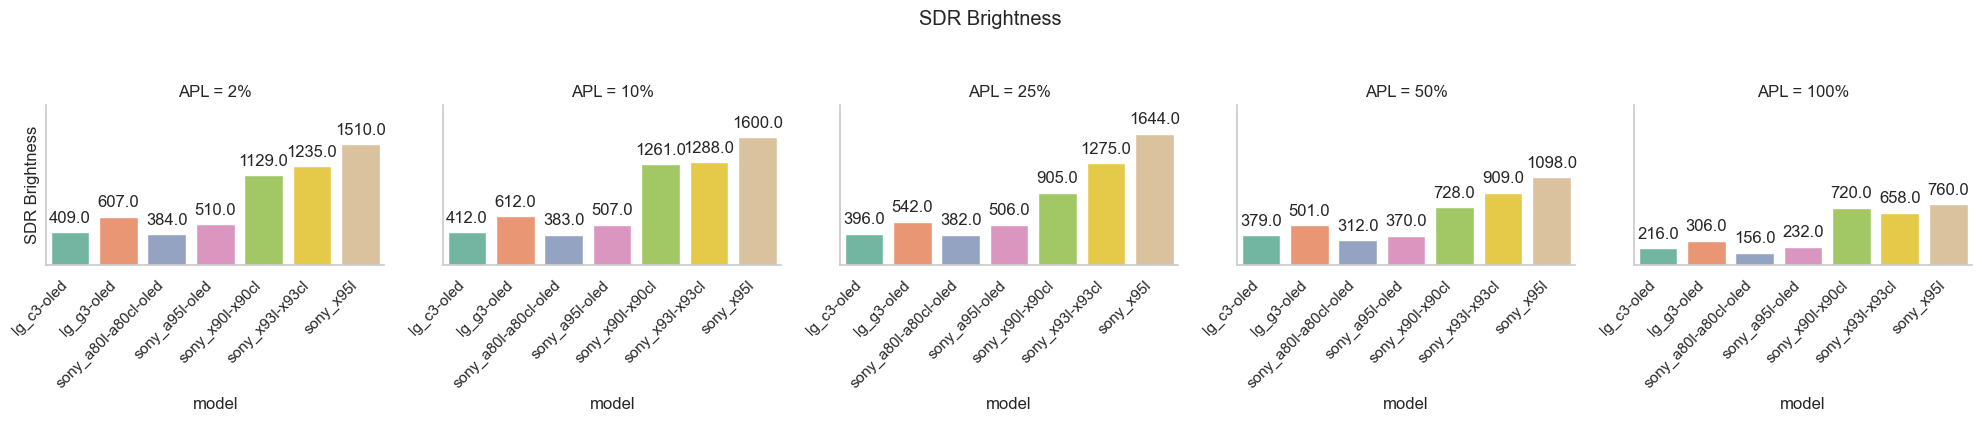

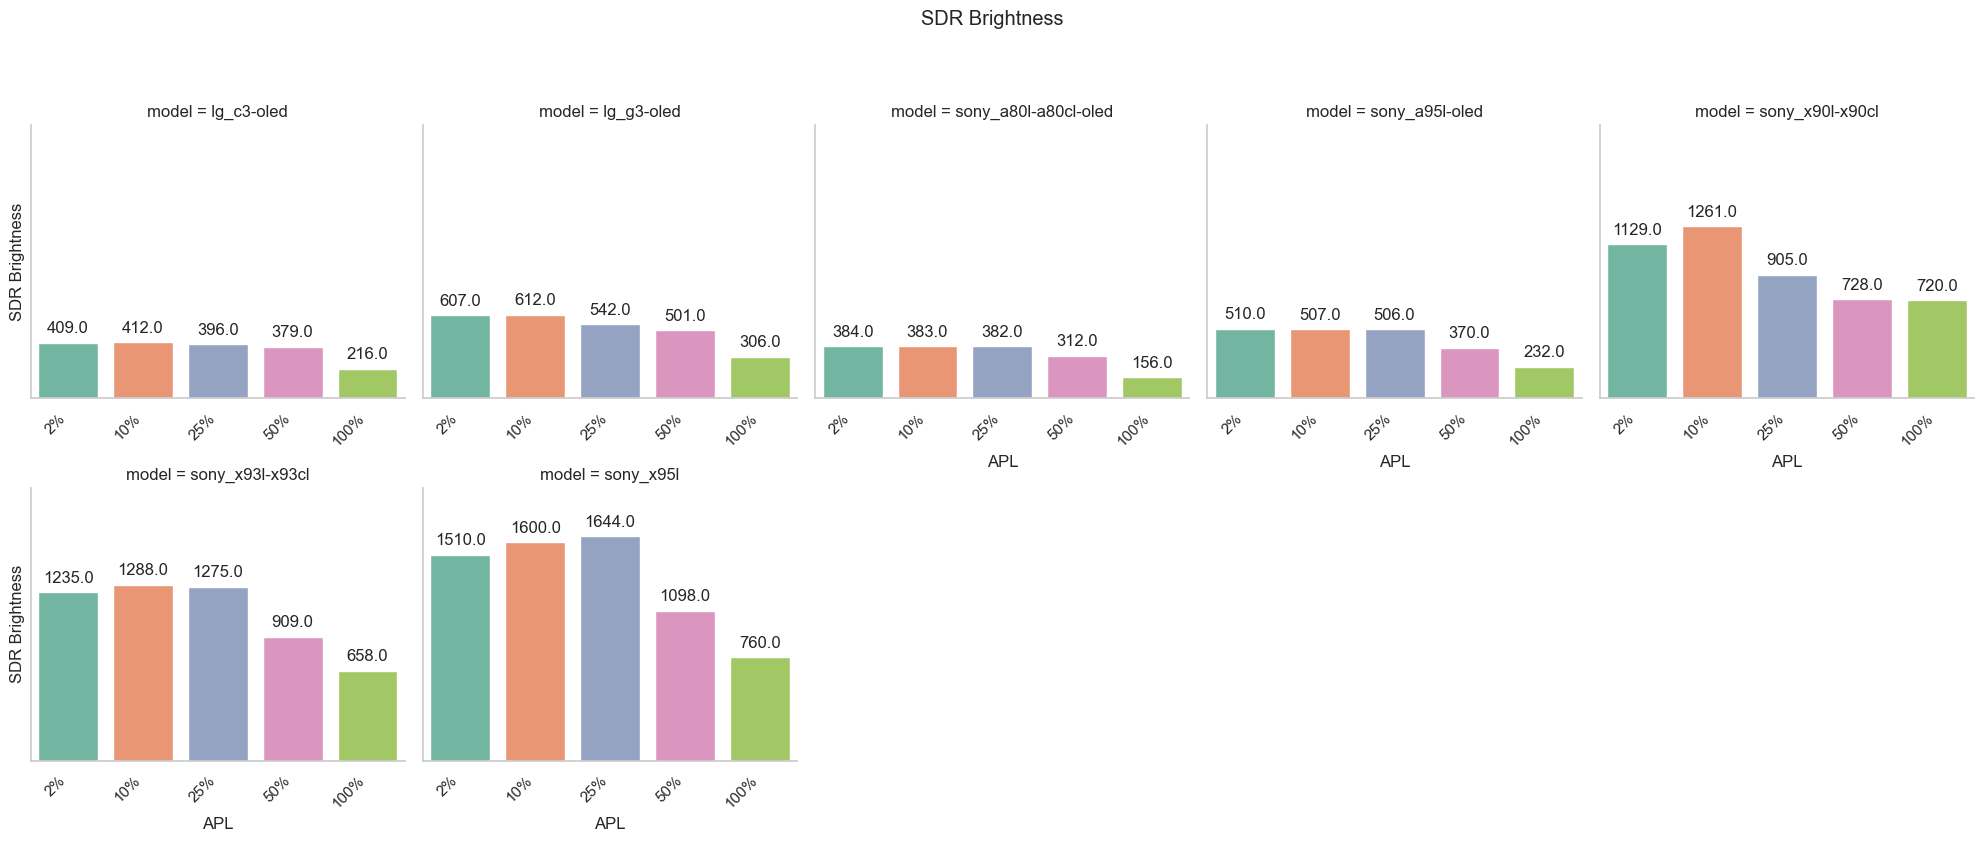

In [240]:
df = get_data_detail(measurement_df, target_col, mode=mode)
plot_lines(df, col_x="APL", col_y=target_col, col_color="model")
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="APL", facet_yticks=facet_yticks, facet_ylims=facet_ylims)
plotsns_facet_bar(df, col_x="APL", col_y=target_col, col_facet="model", facet_yticks=facet_yticks, facet_ylims=facet_ylims)

## Viewing Angle

In [243]:
target_col = 'Viewing Angle'
mode="normal"
facet_yticks = []
facet_ylims = (0, 80)

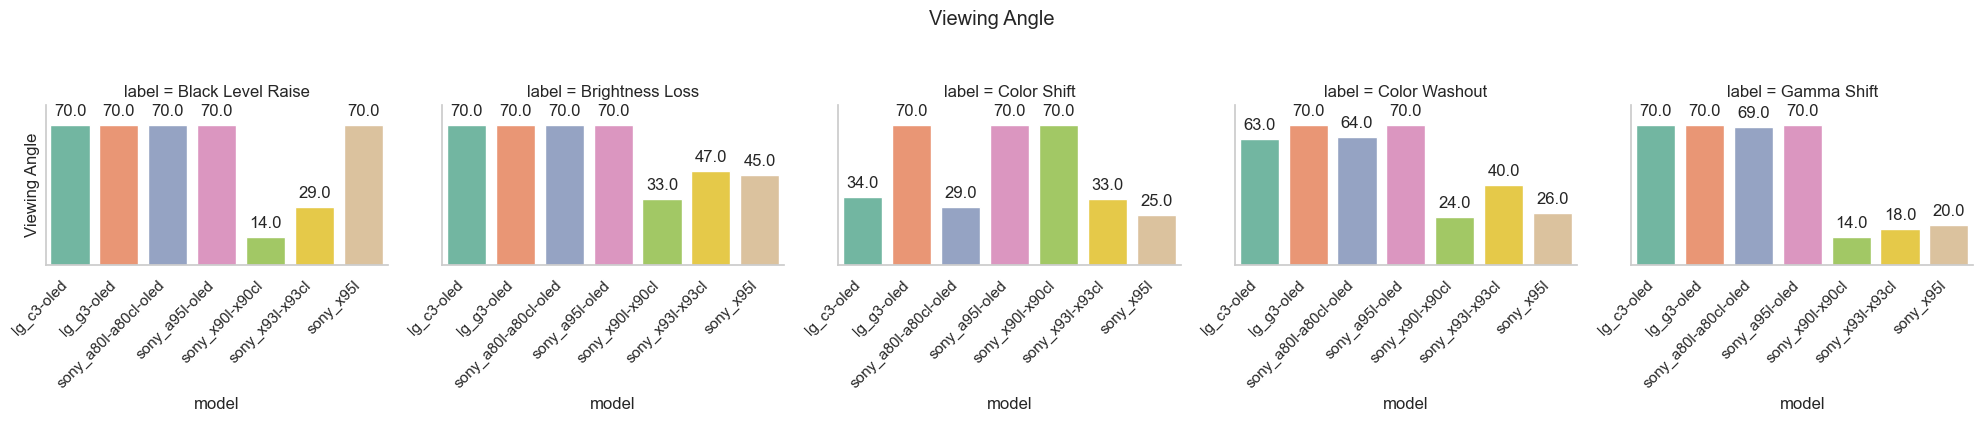

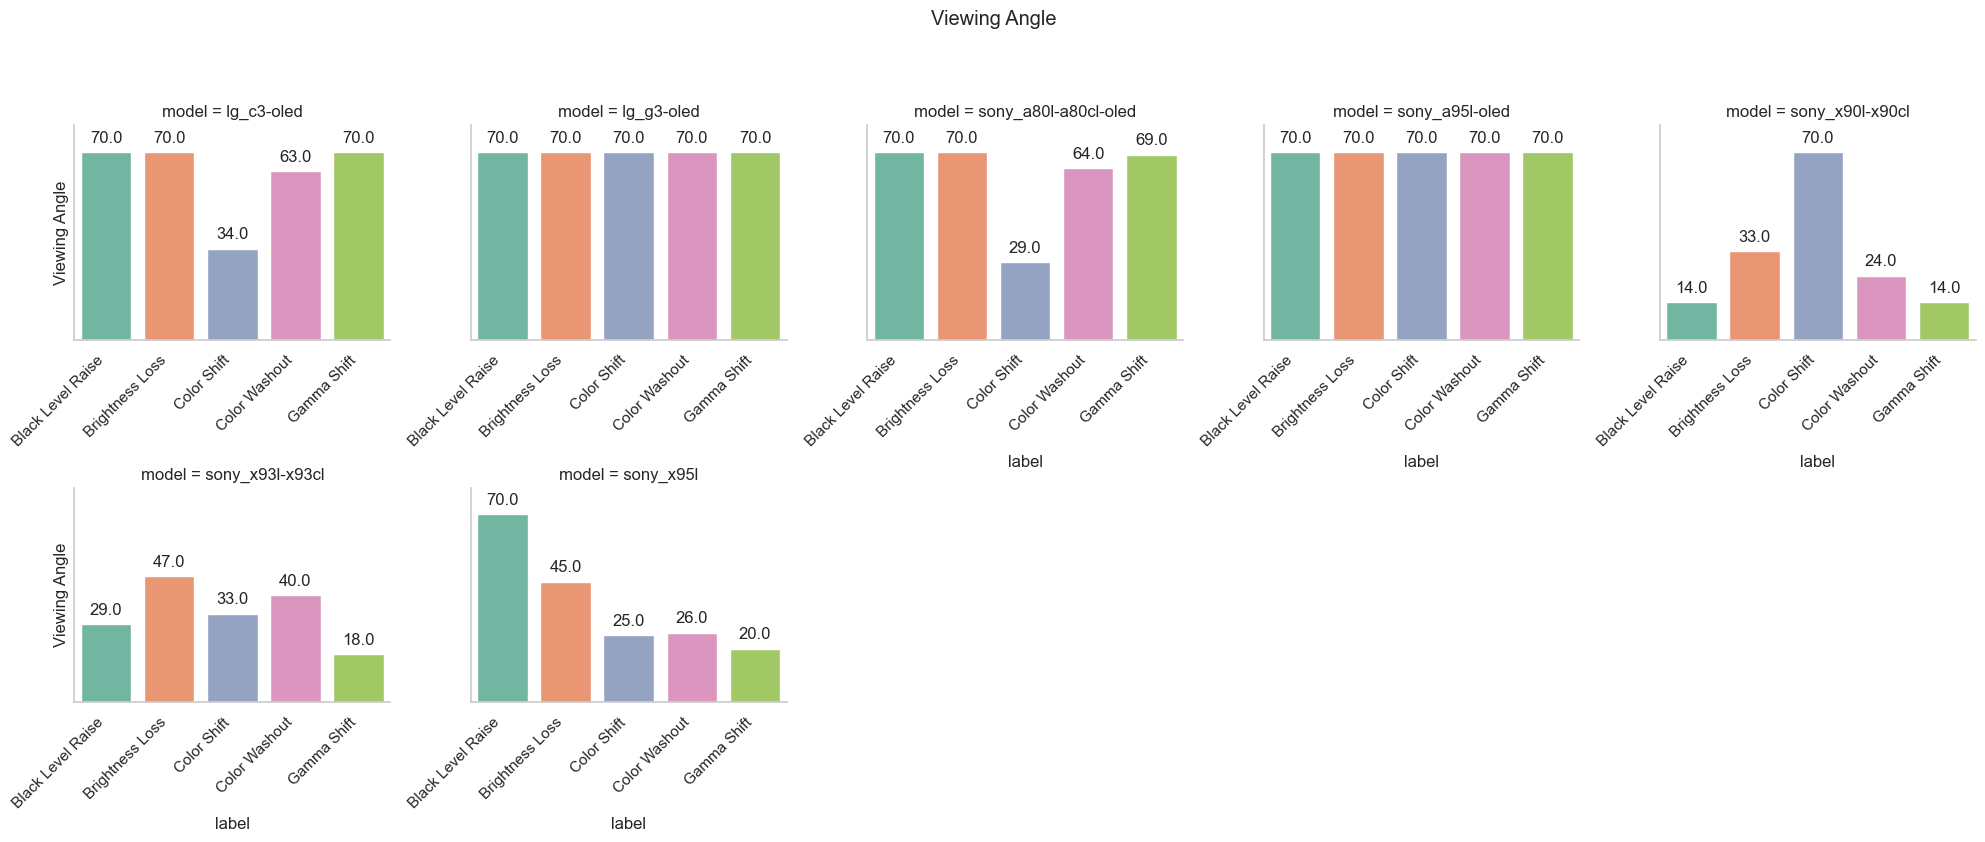

In [245]:
df = get_data_detail(measurement_df, target_col, mode=mode)
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label", facet_yticks=facet_yticks, facet_ylims=facet_ylims)
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model", facet_yticks=facet_yticks, facet_ylims=facet_ylims)

## Color Volume

In [317]:
target_col = 'Color Volume'
df_b = get_data_detail(measurement_df, target_col, mode=mode)

In [318]:
facet_ylims = {}
facet_ylims.update({k:(0, 1000) for k in range(1,5,1)})
facet_ylims.update({k:(0, 1800) for k in range(5,7,1)})
df = df_b[~df_b['label'].isin(["DCI", "BT2020"])]

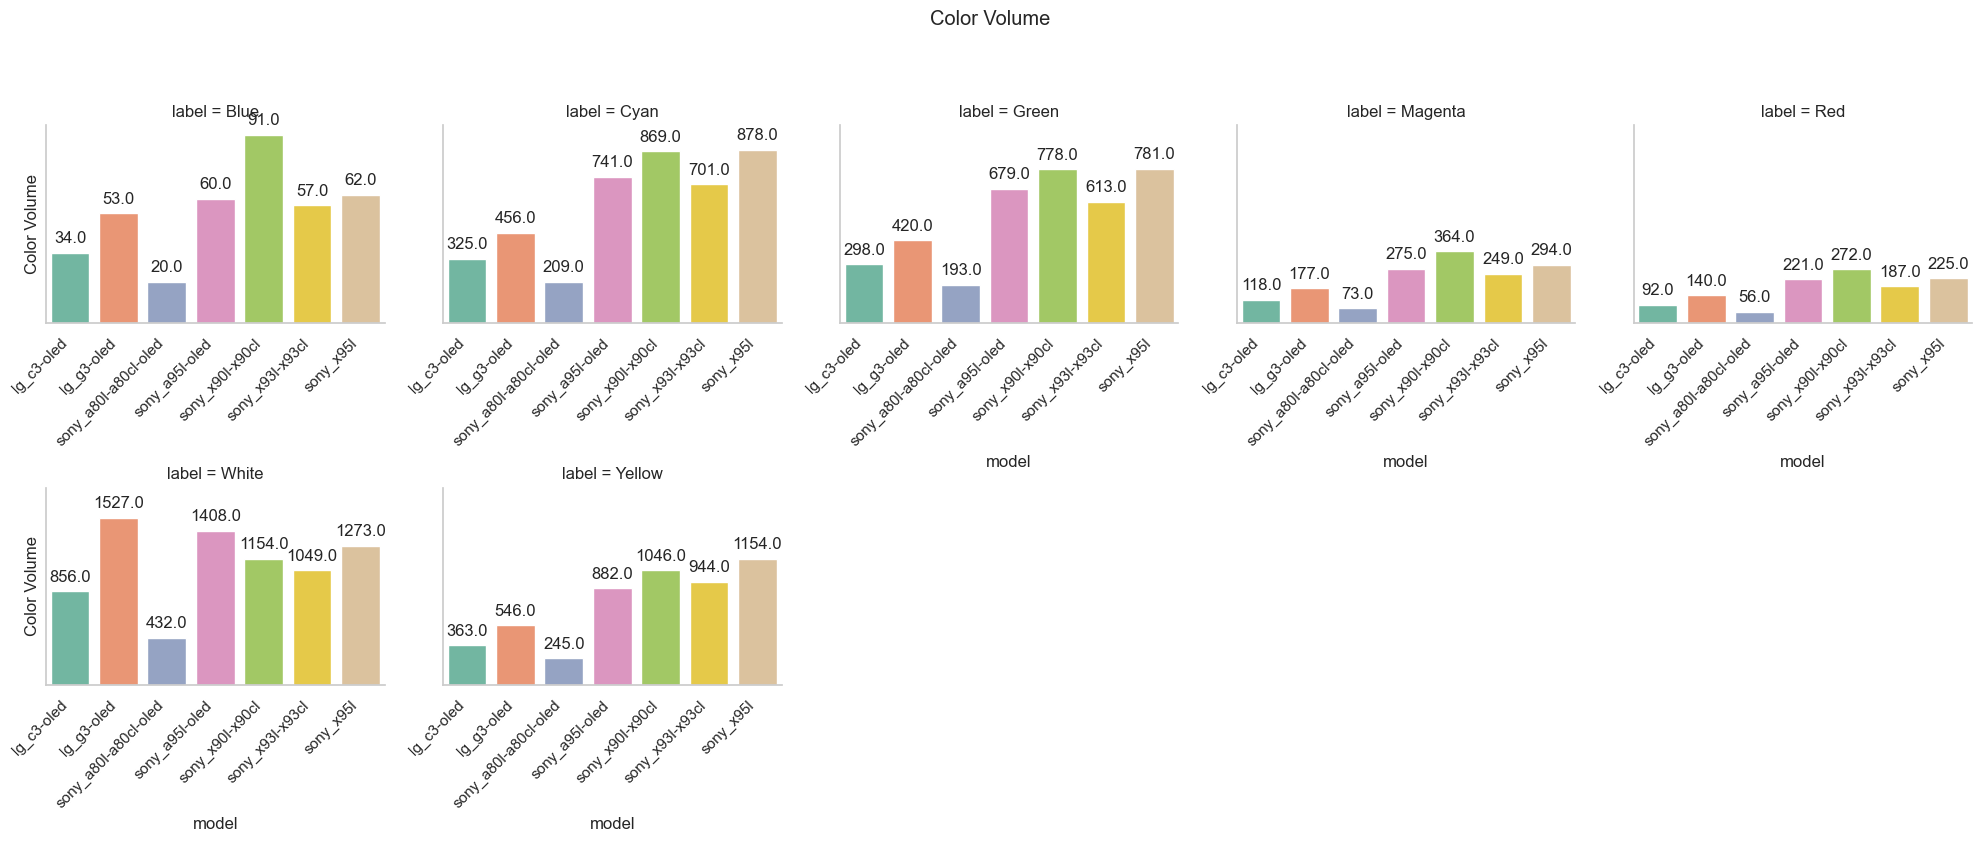

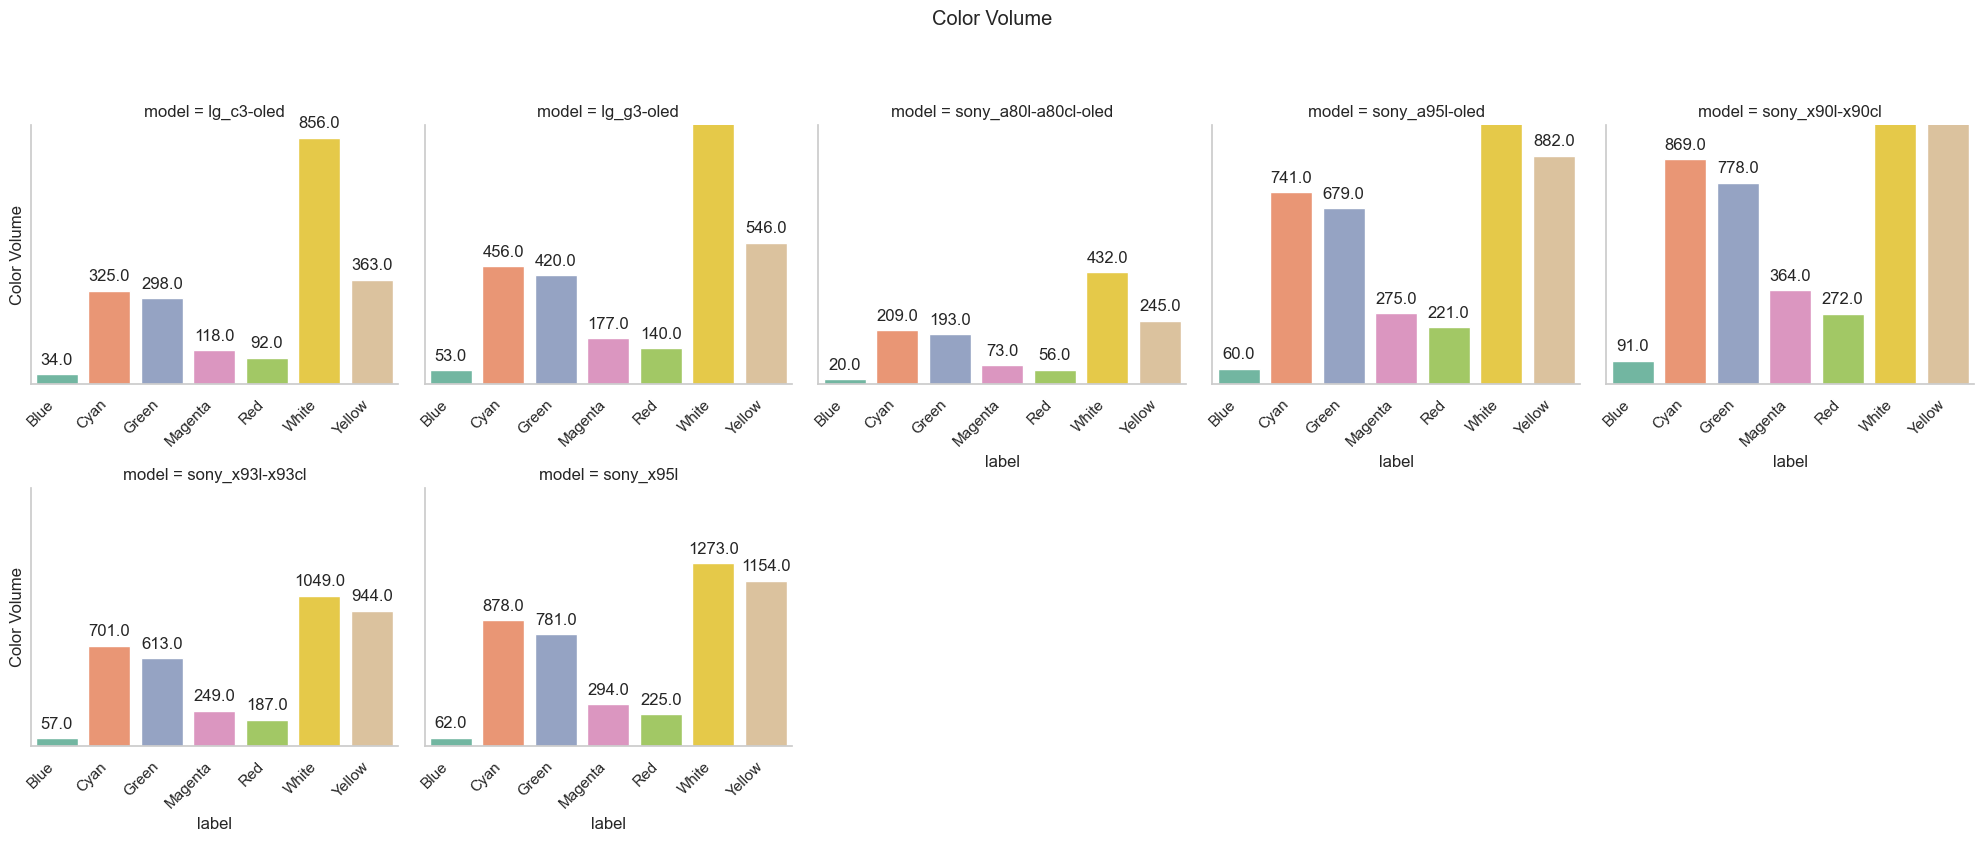

In [319]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label", facet_ylims=facet_ylims)
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model", facet_ylims=facet_ylims)

In [322]:
facet_ylims=(0,100)
df = df_b[df_b['label'].isin(["DCI", "BT2020"])]

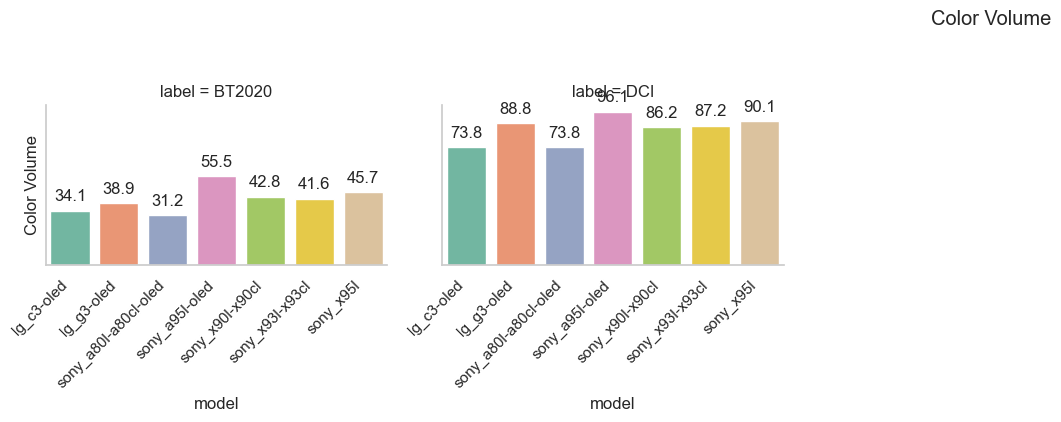

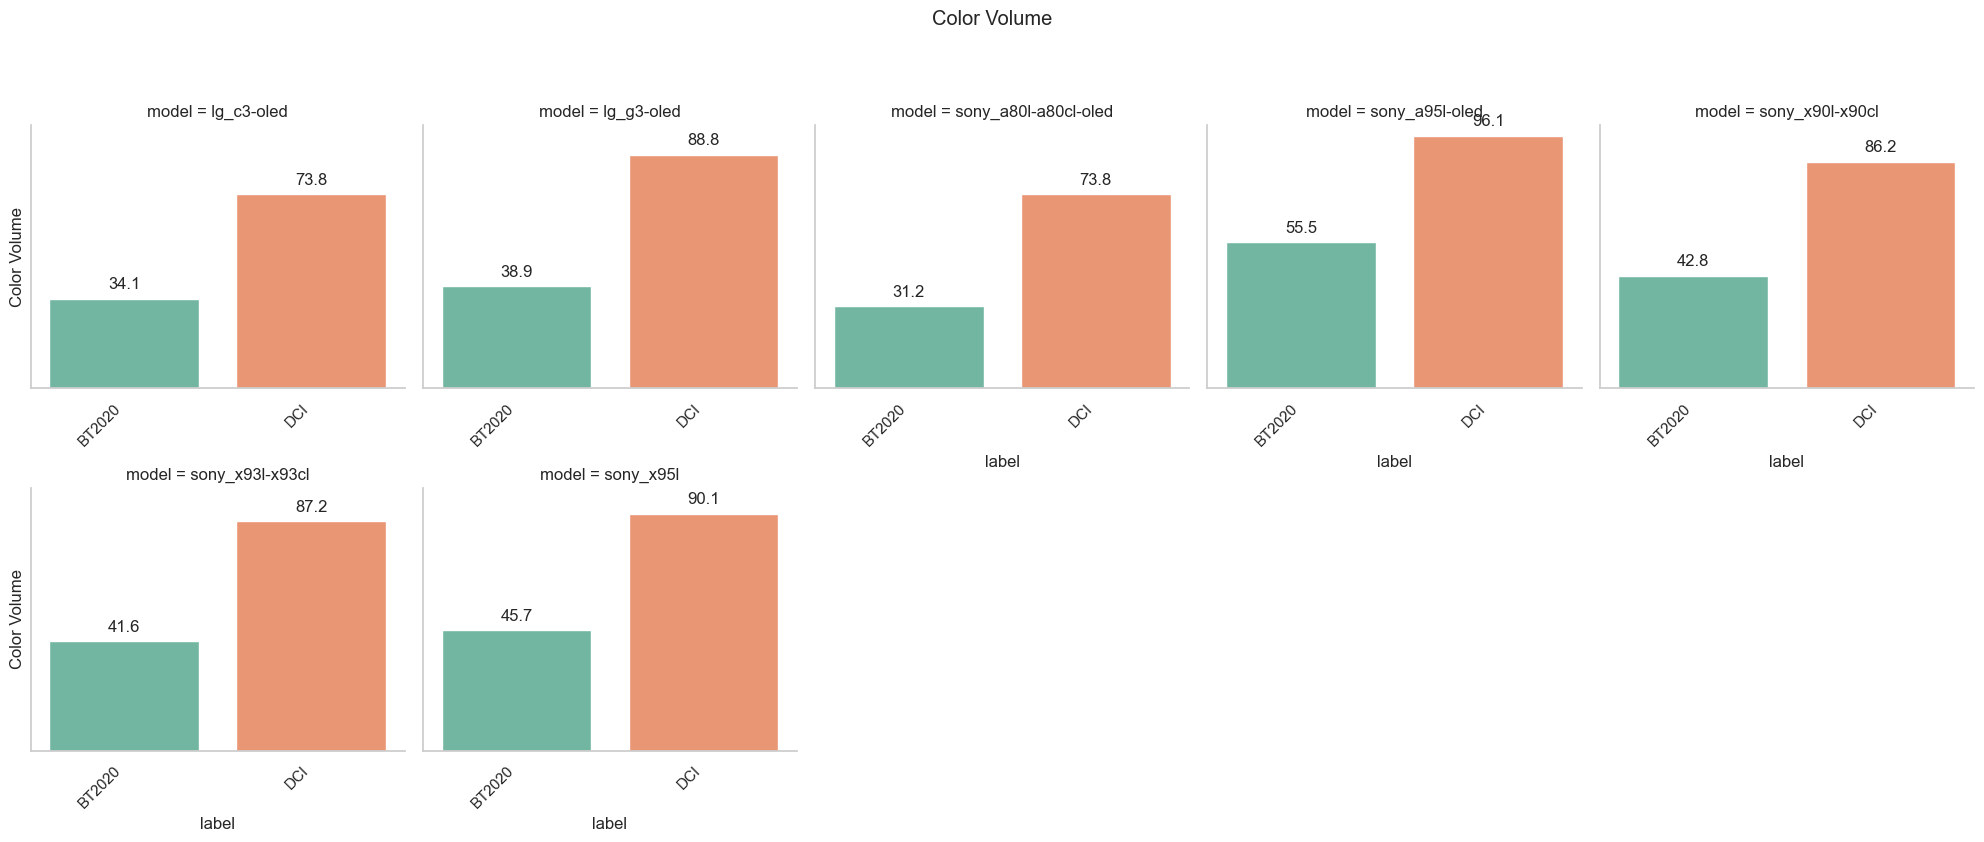

In [323]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label", facet_ylims=facet_ylims)
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model", facet_ylims=facet_ylims)

## Color Gamut

In [327]:
target_col =  "Color Gamut"
df = get_data_detail(measurement_df, target_col)

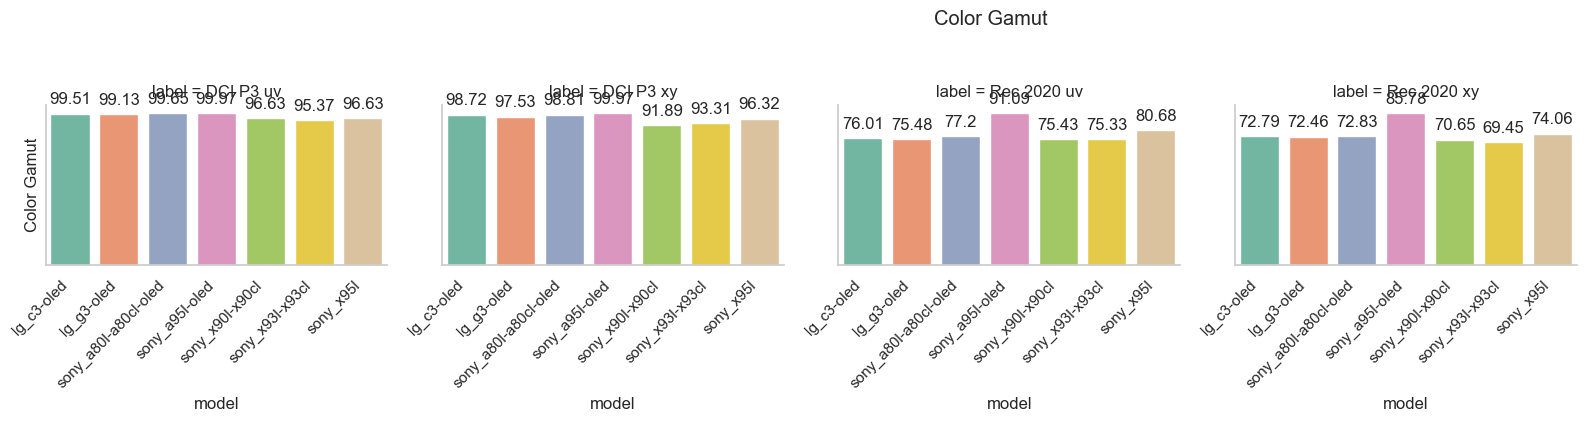

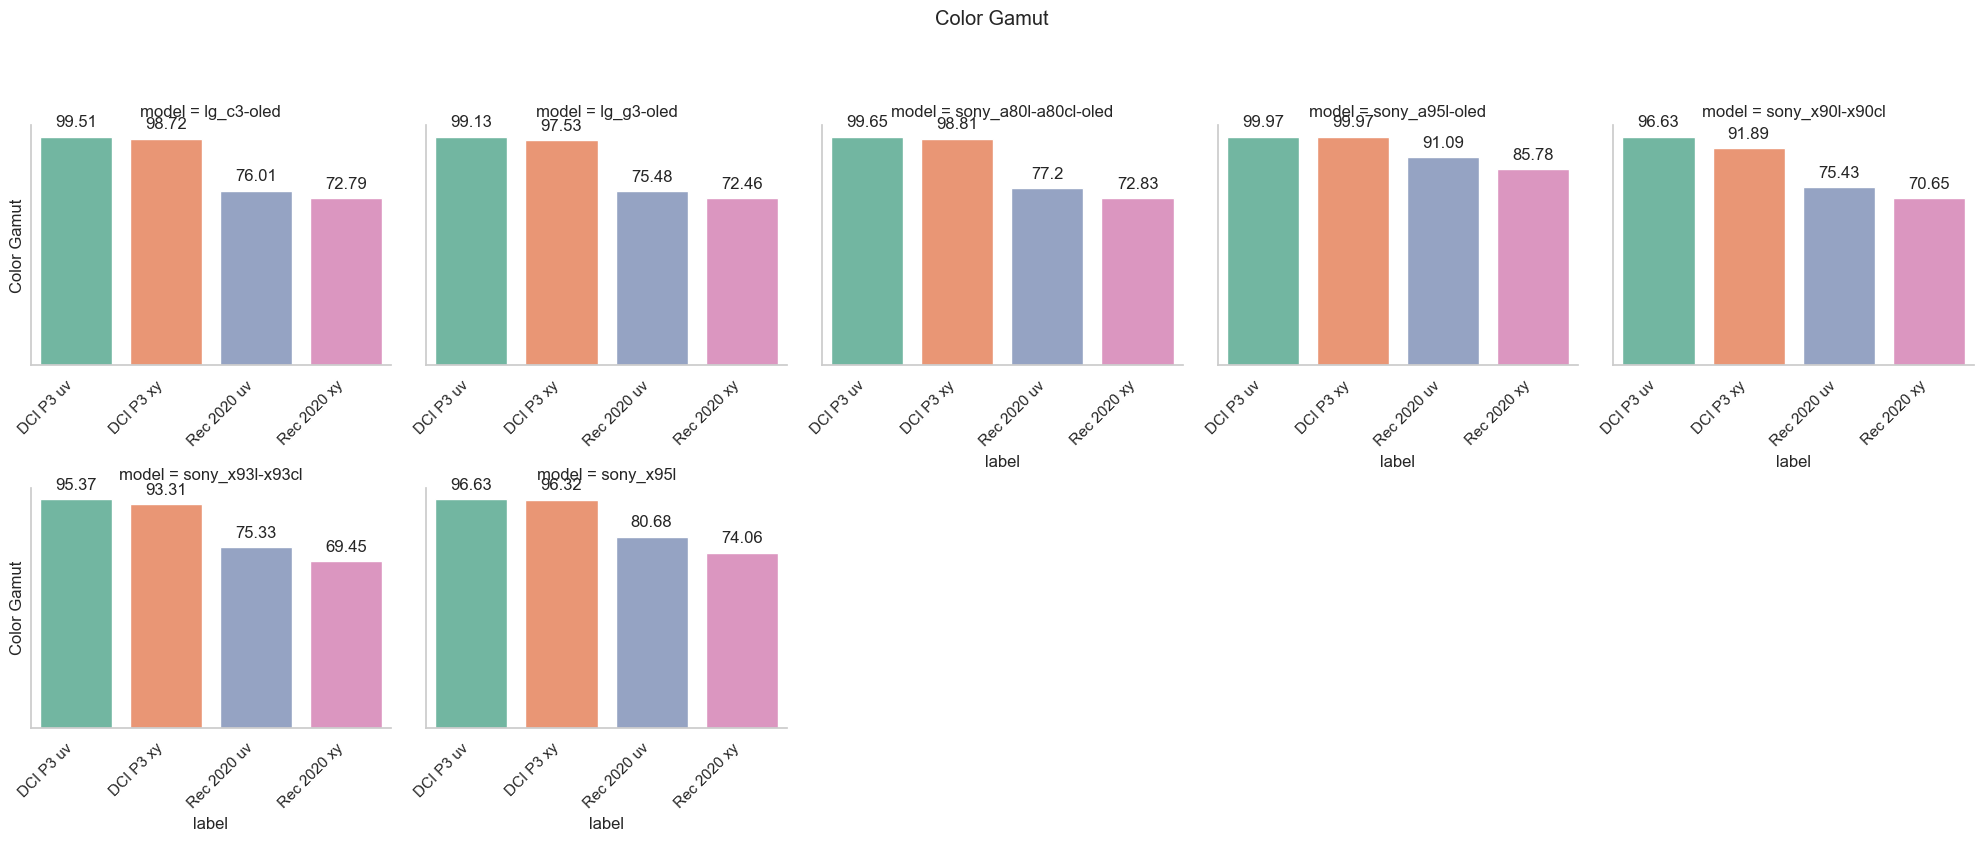

In [328]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Pre Calibration

In [336]:
target_col =  "Pre Calibration"
df = get_data_detail(measurement_df, target_col)

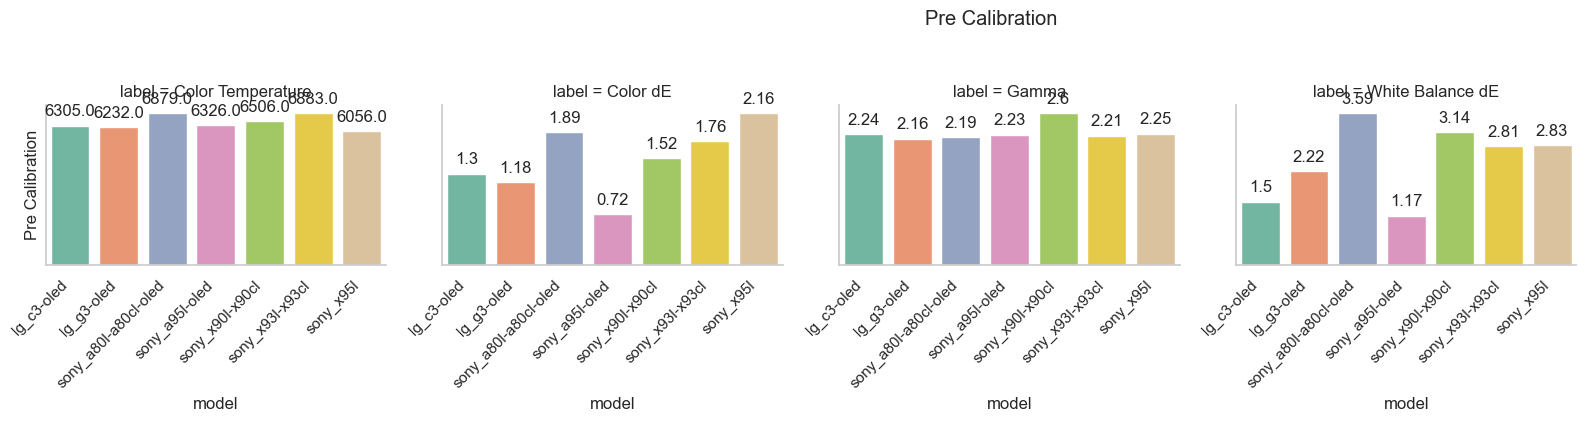

In [337]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")

## Post Calibration

In [338]:
target_col =  "Post Calibration"
df = get_data_detail(measurement_df, target_col)

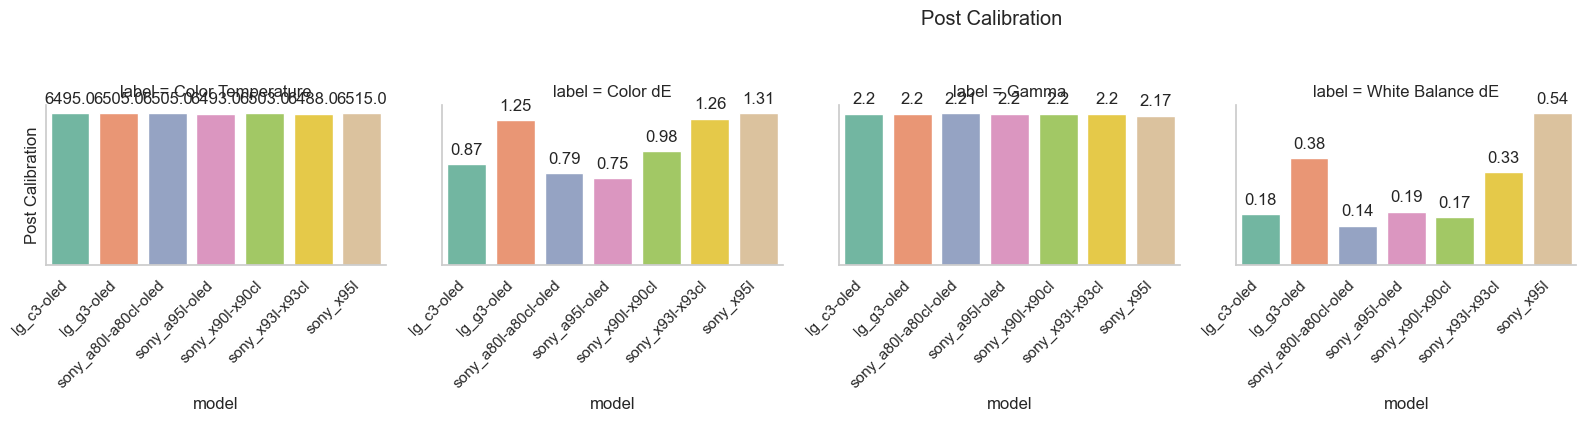

In [340]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")

## Post - Pre Calibration

In [404]:
target_col =  "Pre Calibration"
pre_df = get_data_detail(measurement_df, target_col)
target_col =  "Post Calibration"
post_df = get_data_detail(measurement_df, target_col)

df = post_df.copy().drop([target_col], axis=1)

target_col = "Pre - Post Calibration"
df.loc[:,target_col]=pre_df["Pre Calibration"] - post_df["Post Calibration"]
df.loc[:,target_col] = df.loc[:,target_col].map(lambda x:round(x,1))

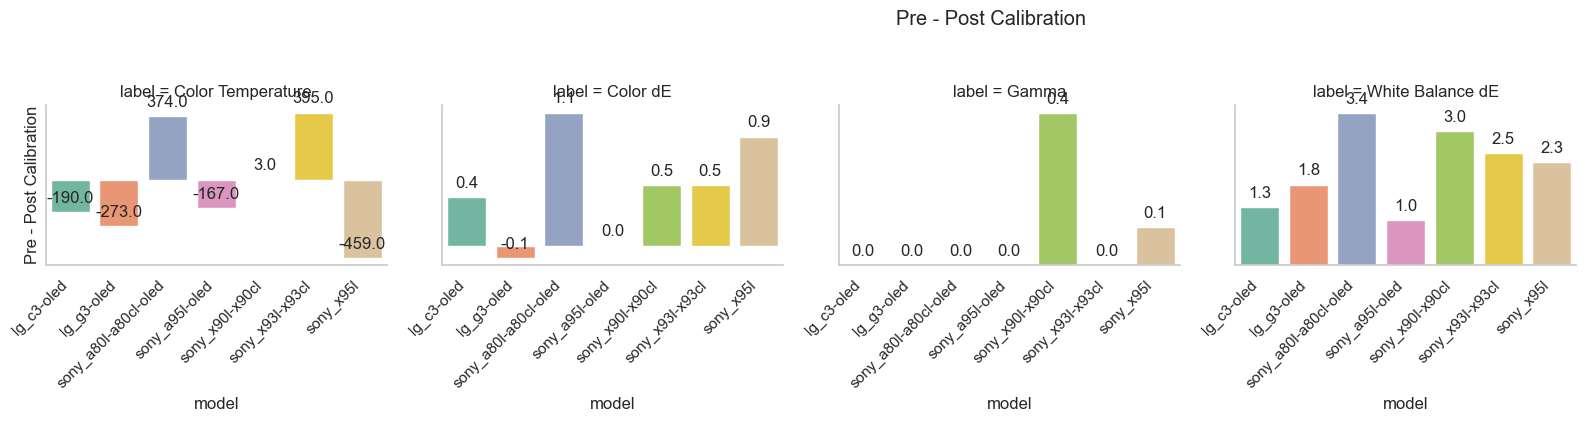

In [405]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")

## PQ EOTF Tracking

In [406]:
target_col =  "PQ EOTF Tracking"
df = get_data_detail(measurement_df, target_col)

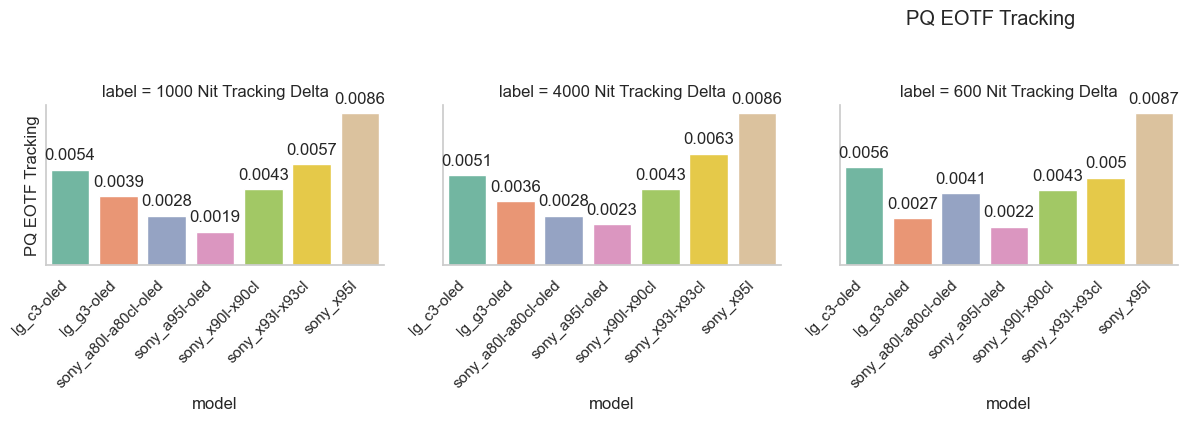

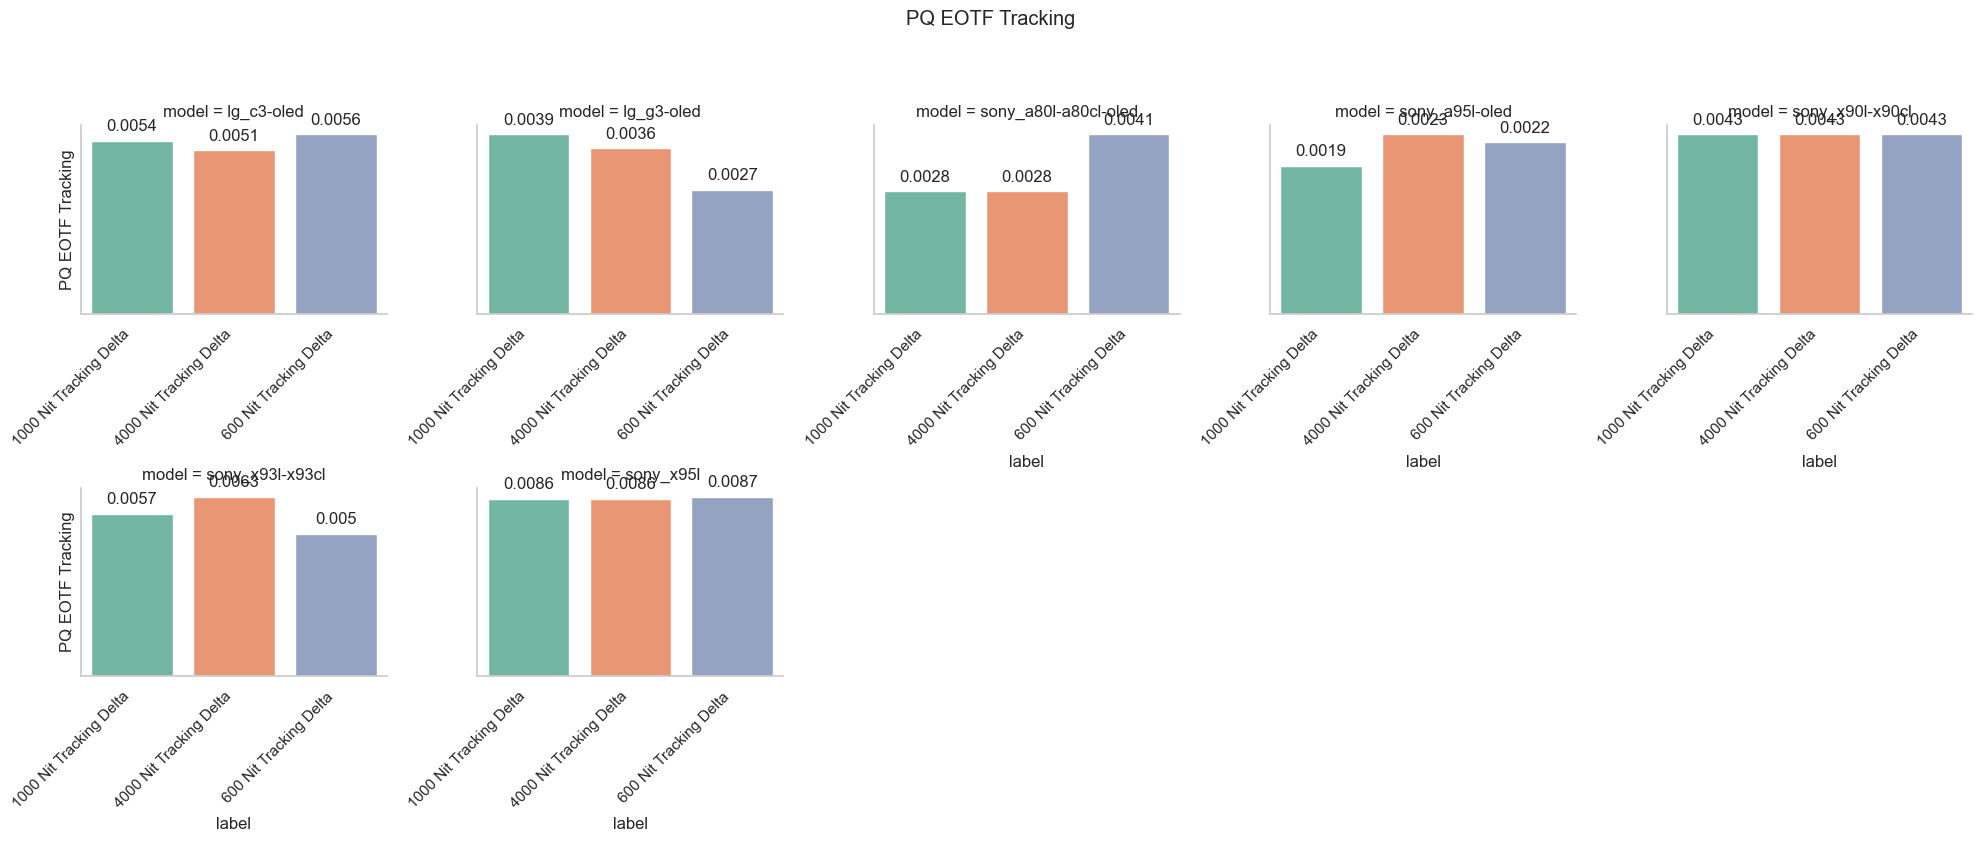

In [407]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Reflections

---

In [342]:
target_col =  "Reflections"
df = get_data_detail(measurement_df, target_col)

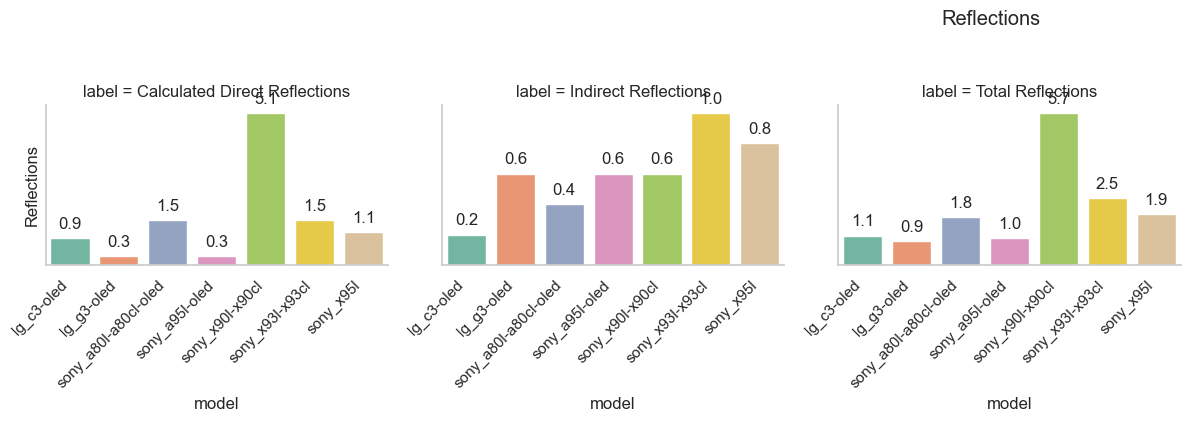

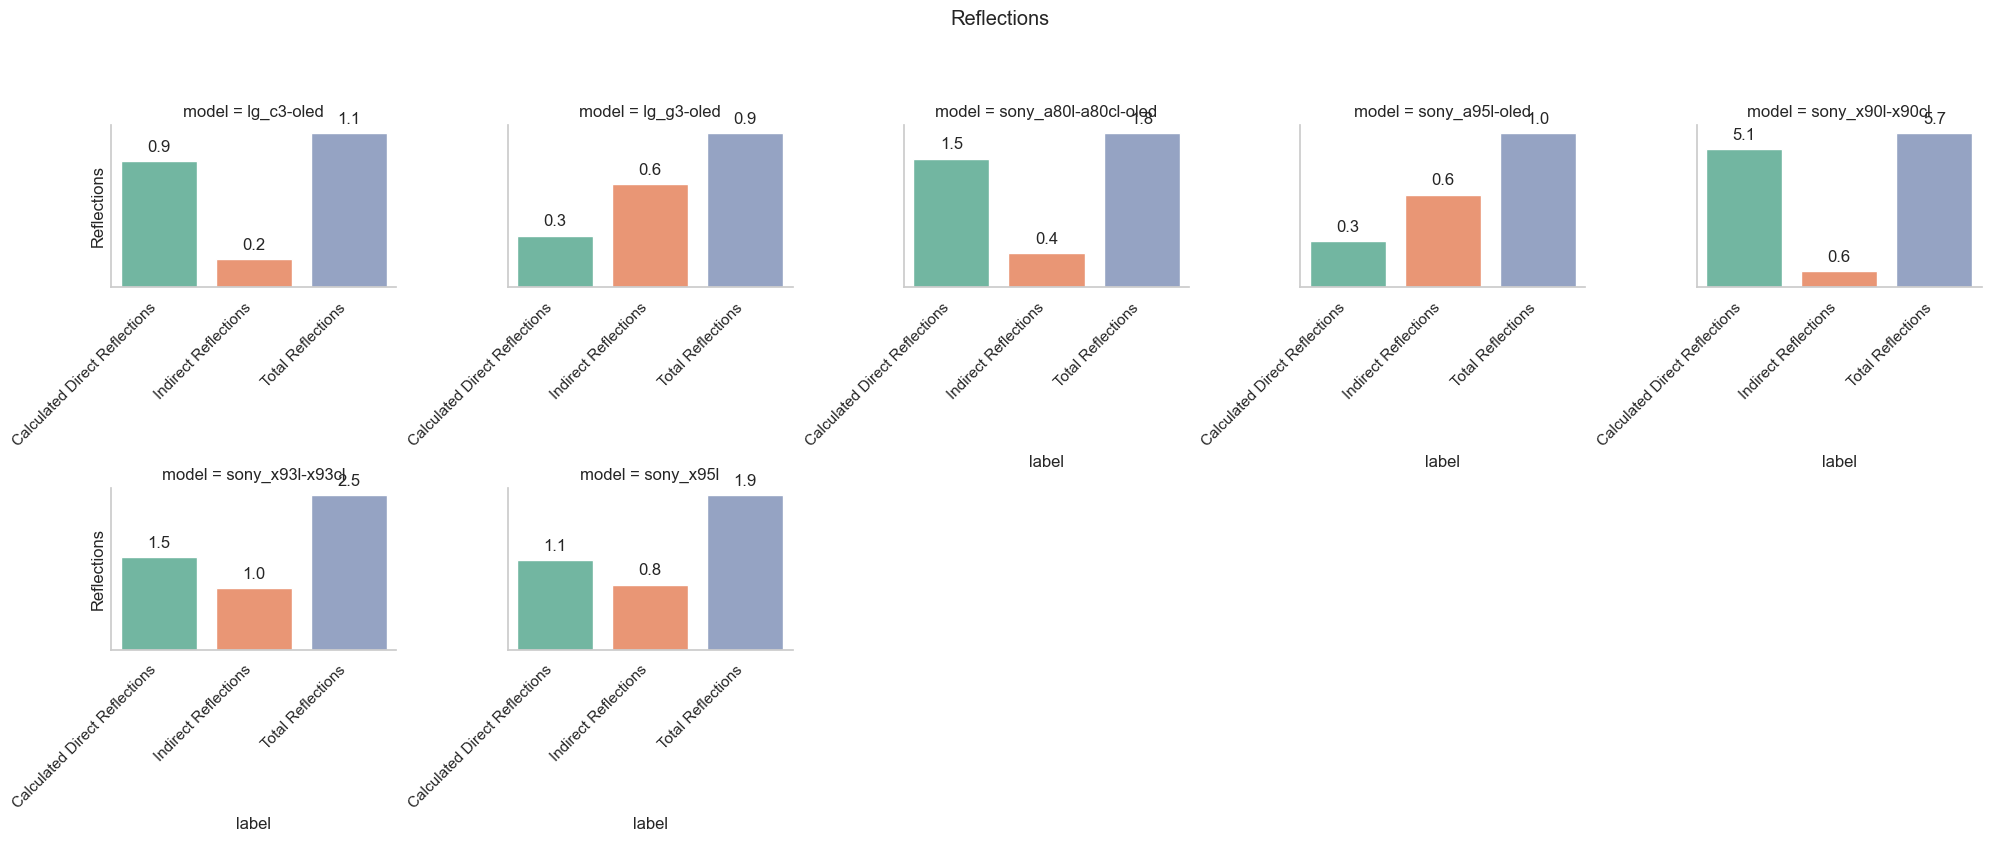

In [343]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## HDR Native Gradient

In [344]:
target_col =  "HDR Native Gradient"
df = get_data_detail(measurement_df, target_col)

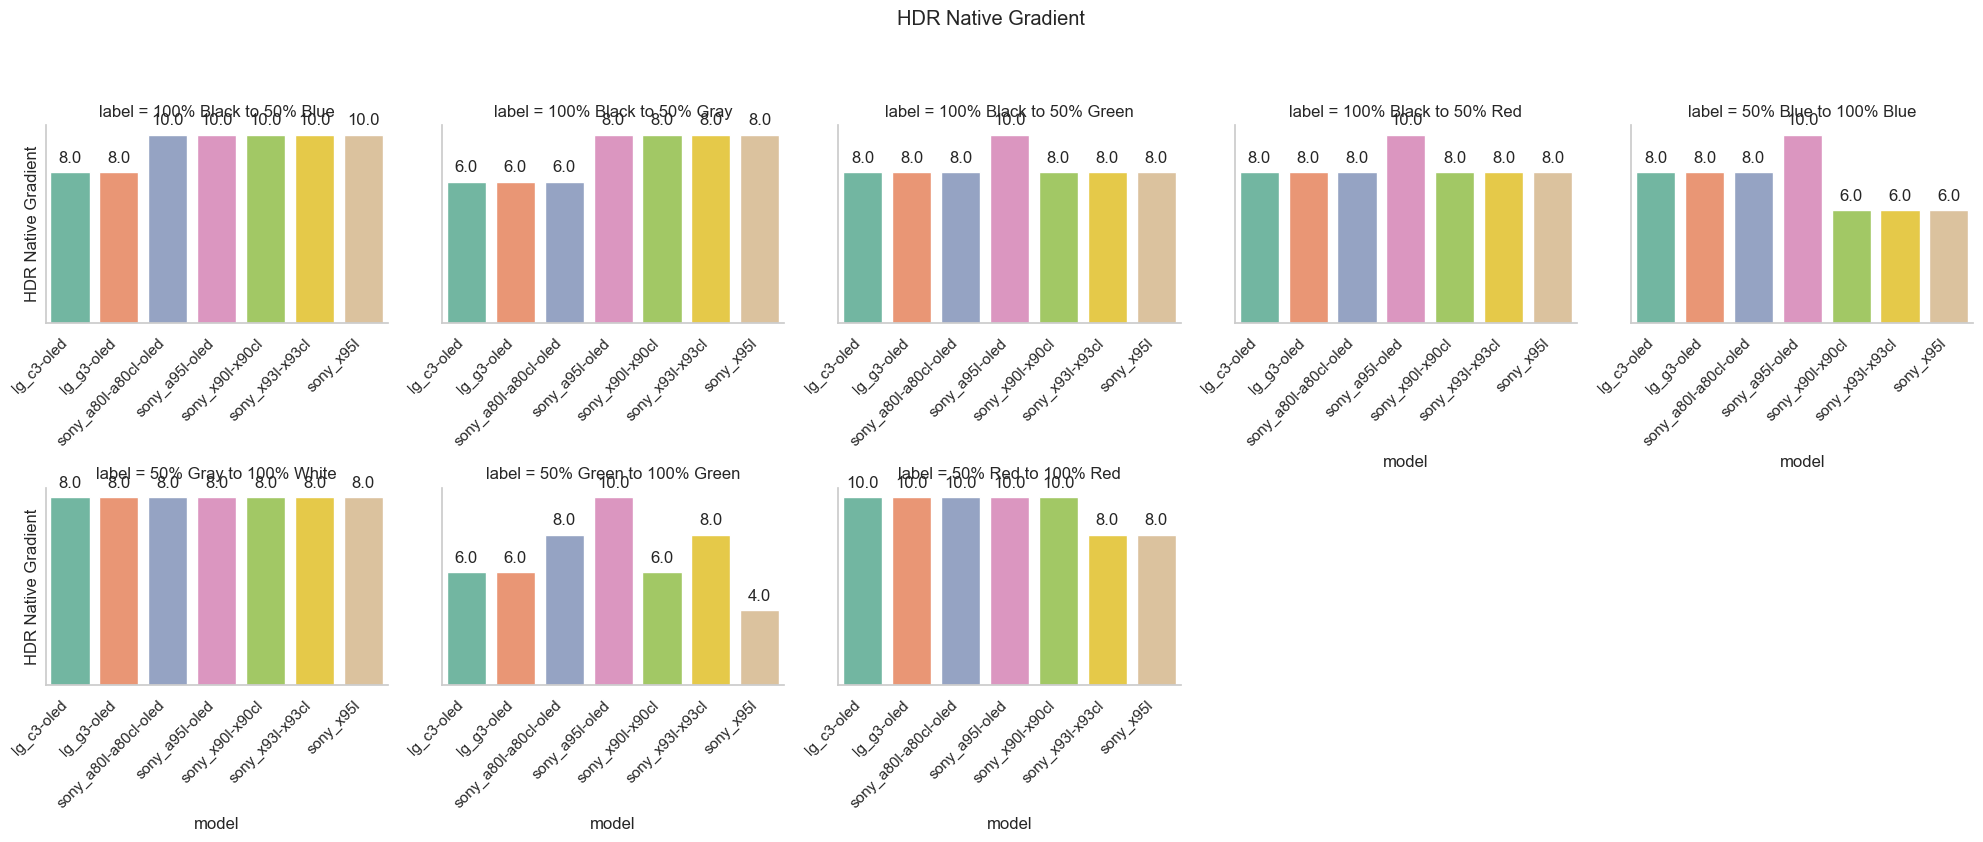

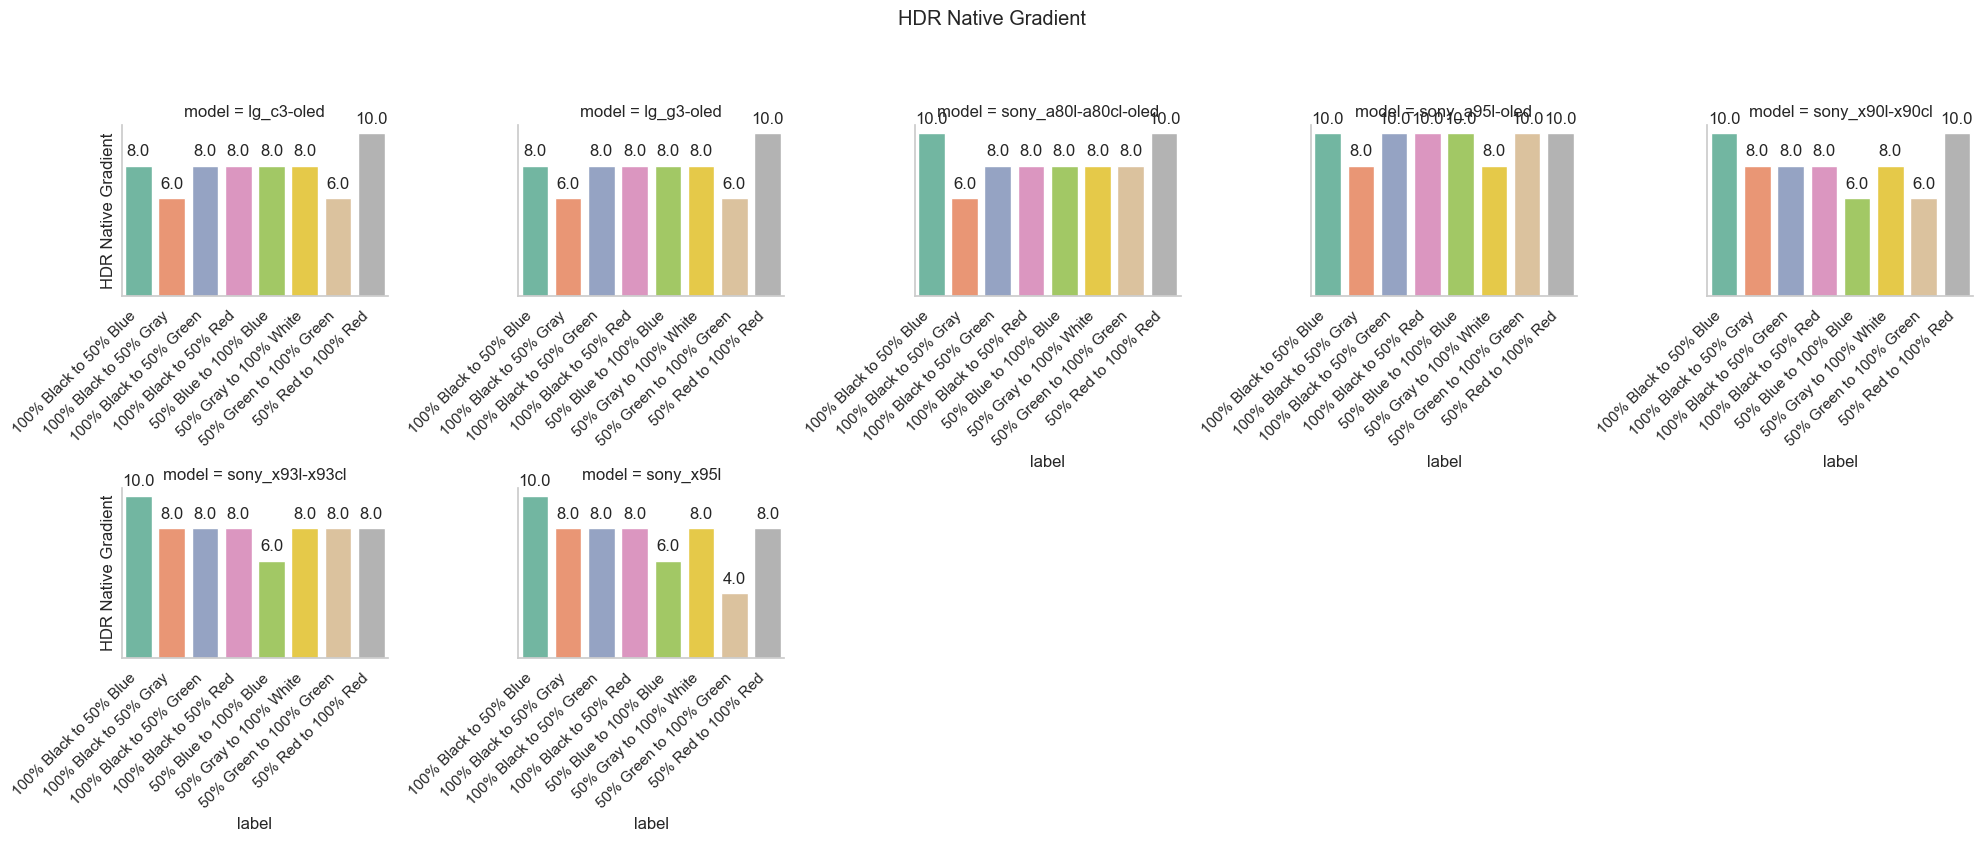

In [345]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

In [346]:
target_col =  "Low-Quality Content Smoothing"
df = get_data_detail(measurement_df, target_col)

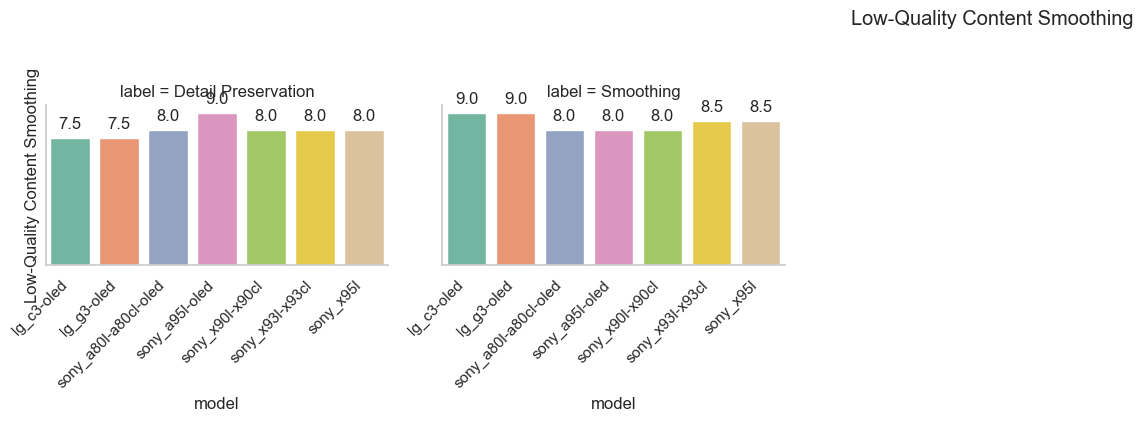

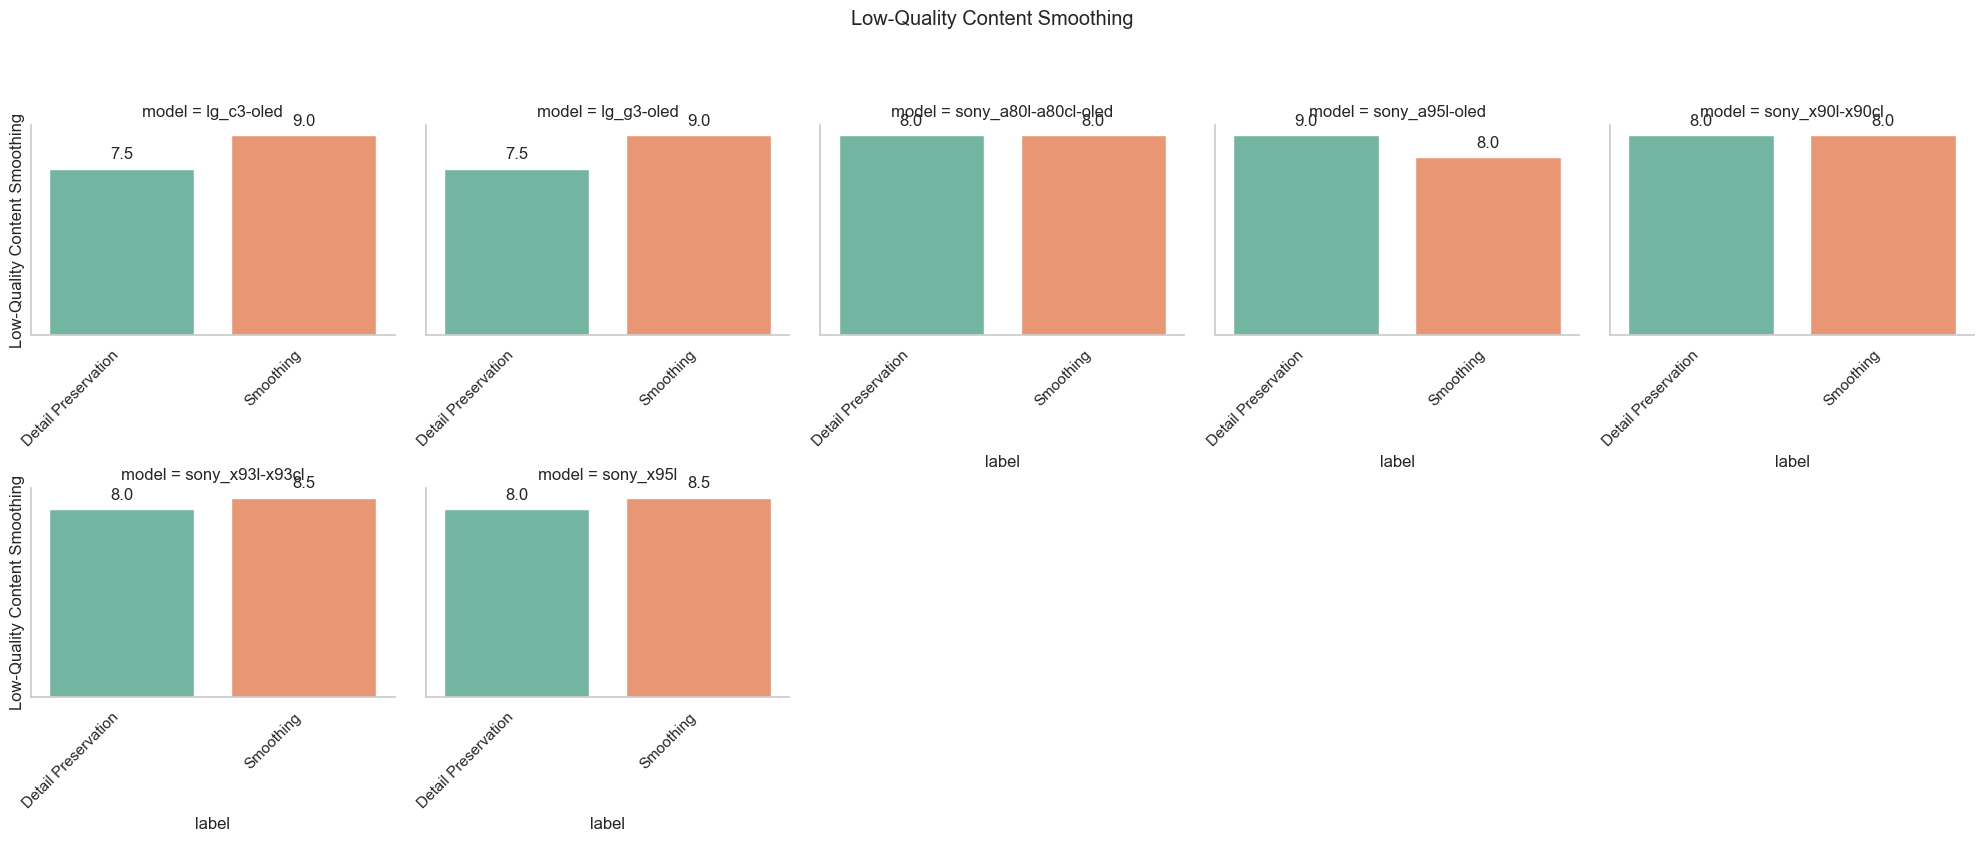

In [347]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Gray Uniformity

In [361]:
target_col =  "Gray Uniformity"
df = get_data_detail(measurement_df, target_col)

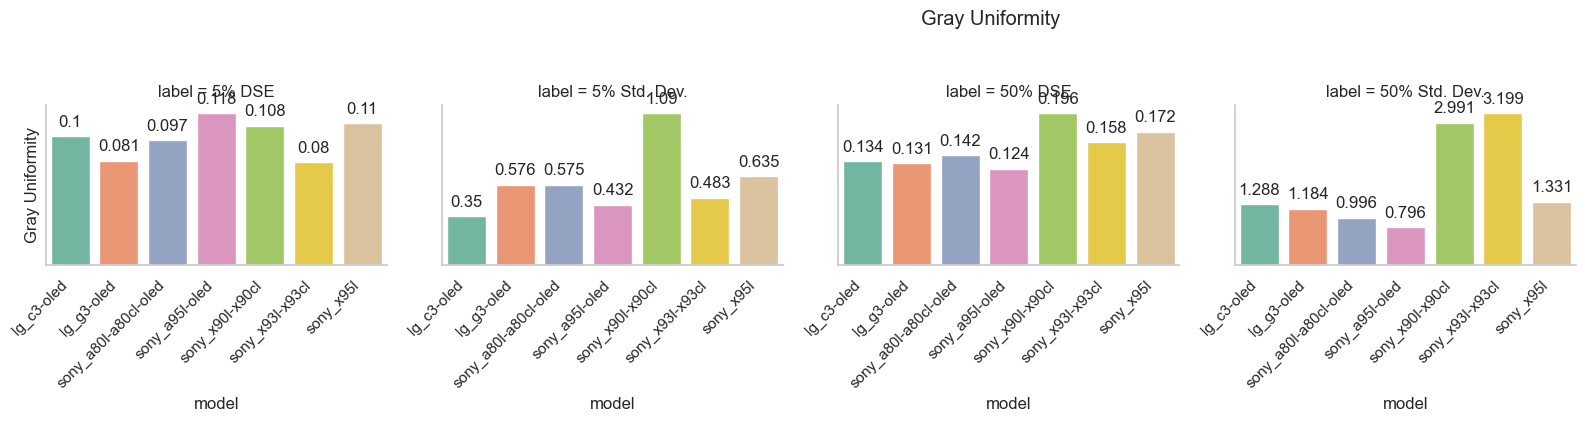

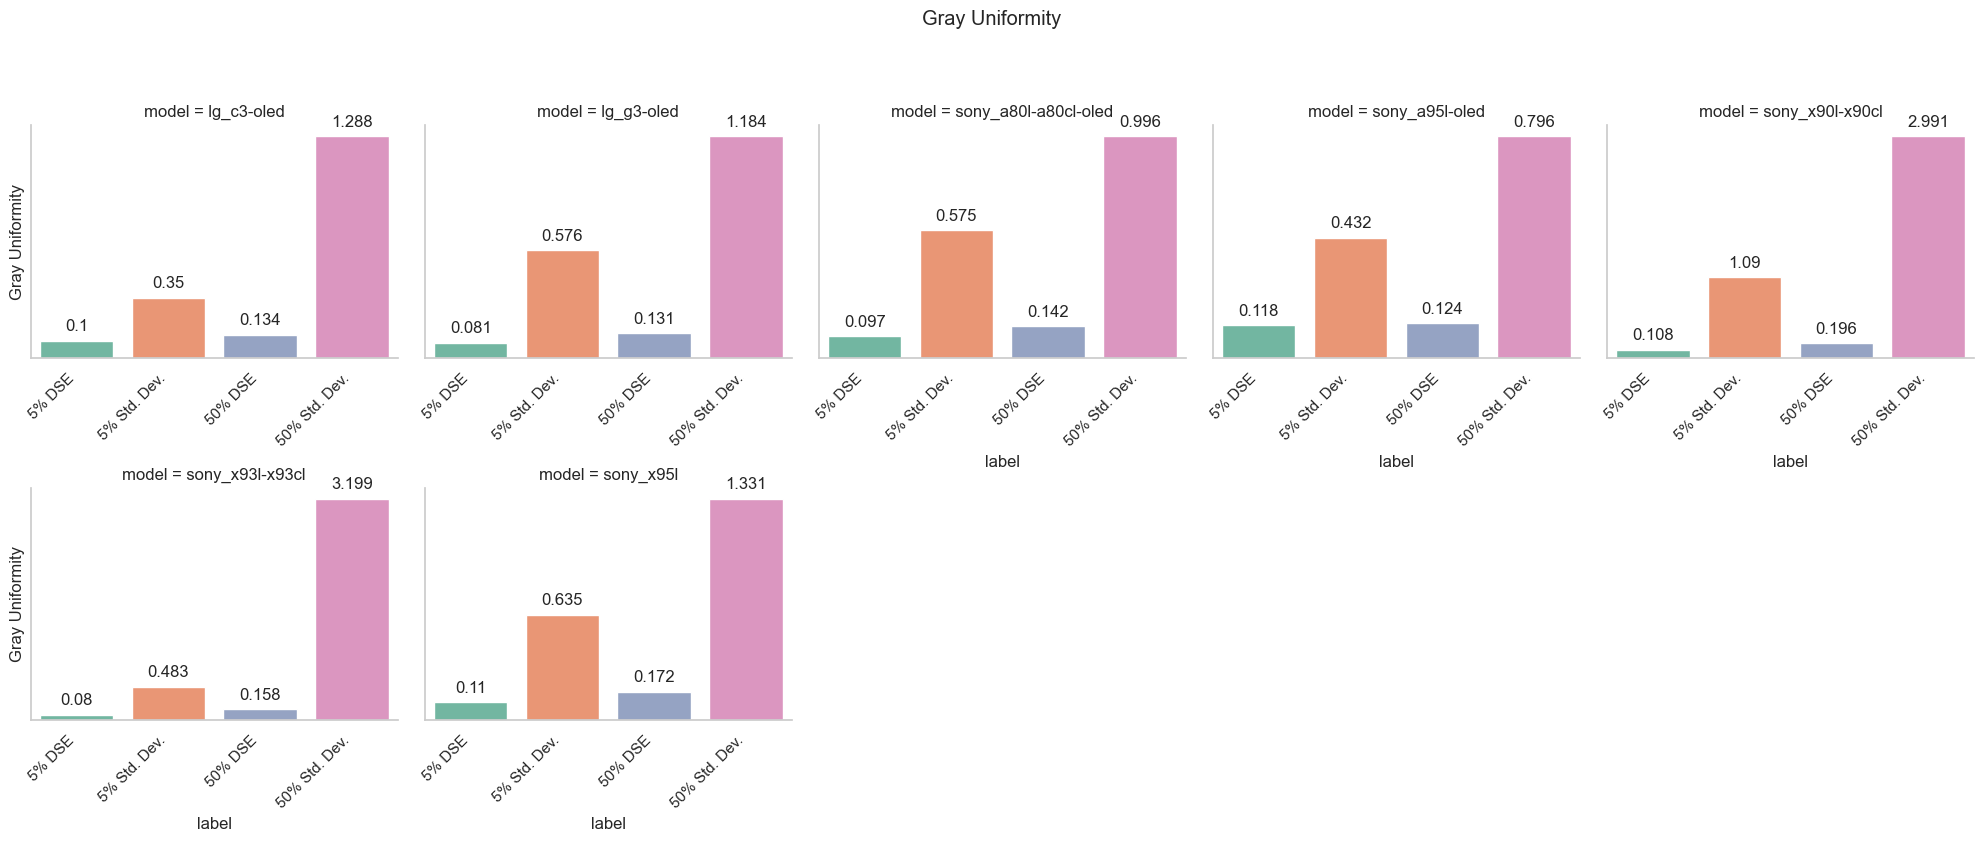

In [362]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Black Uniformity

In [370]:
target_col =  "Black Uniformity"
df = get_data_detail(measurement_df, target_col)

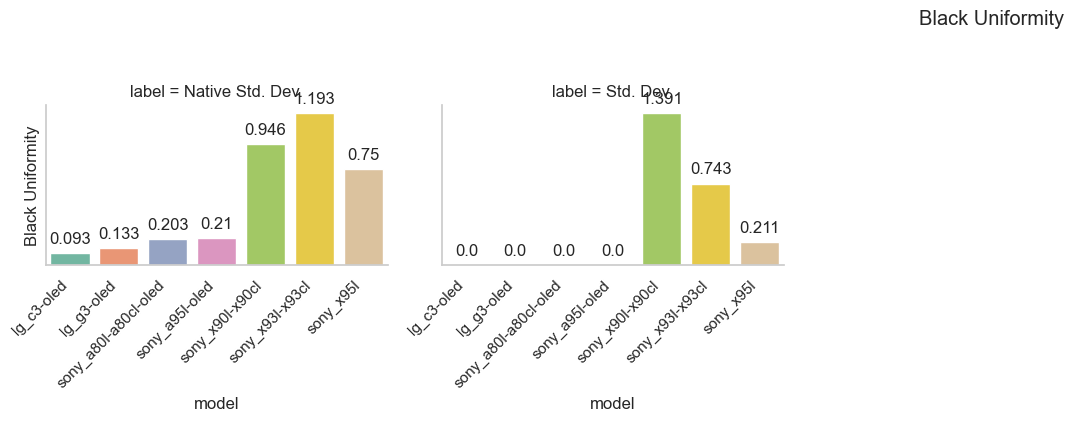

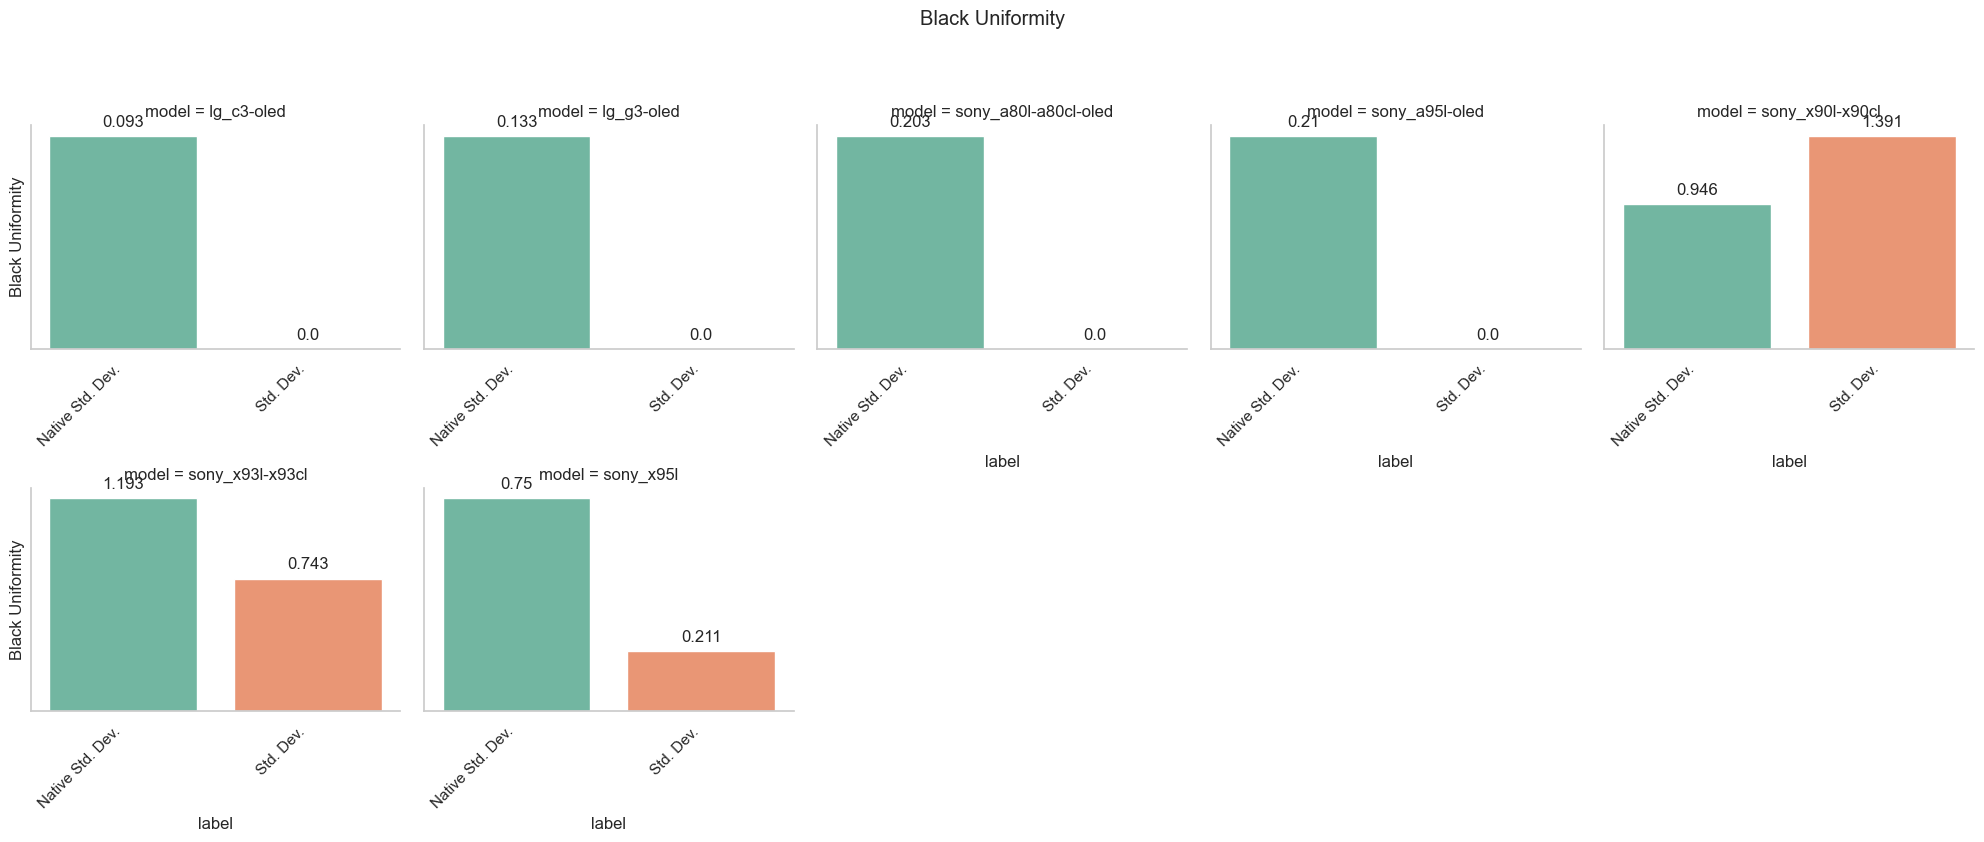

In [371]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Response Time

In [376]:
target_col =  "Response Time"
df = get_data_detail(measurement_df, target_col)

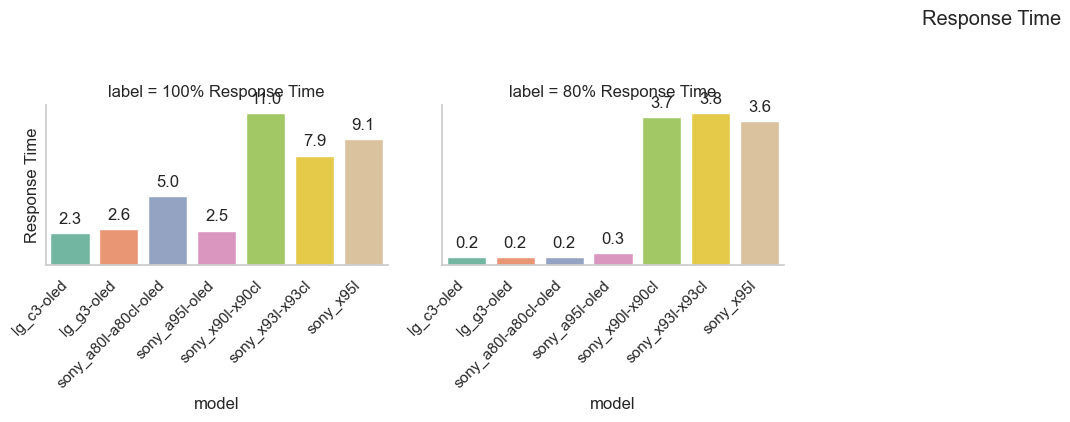

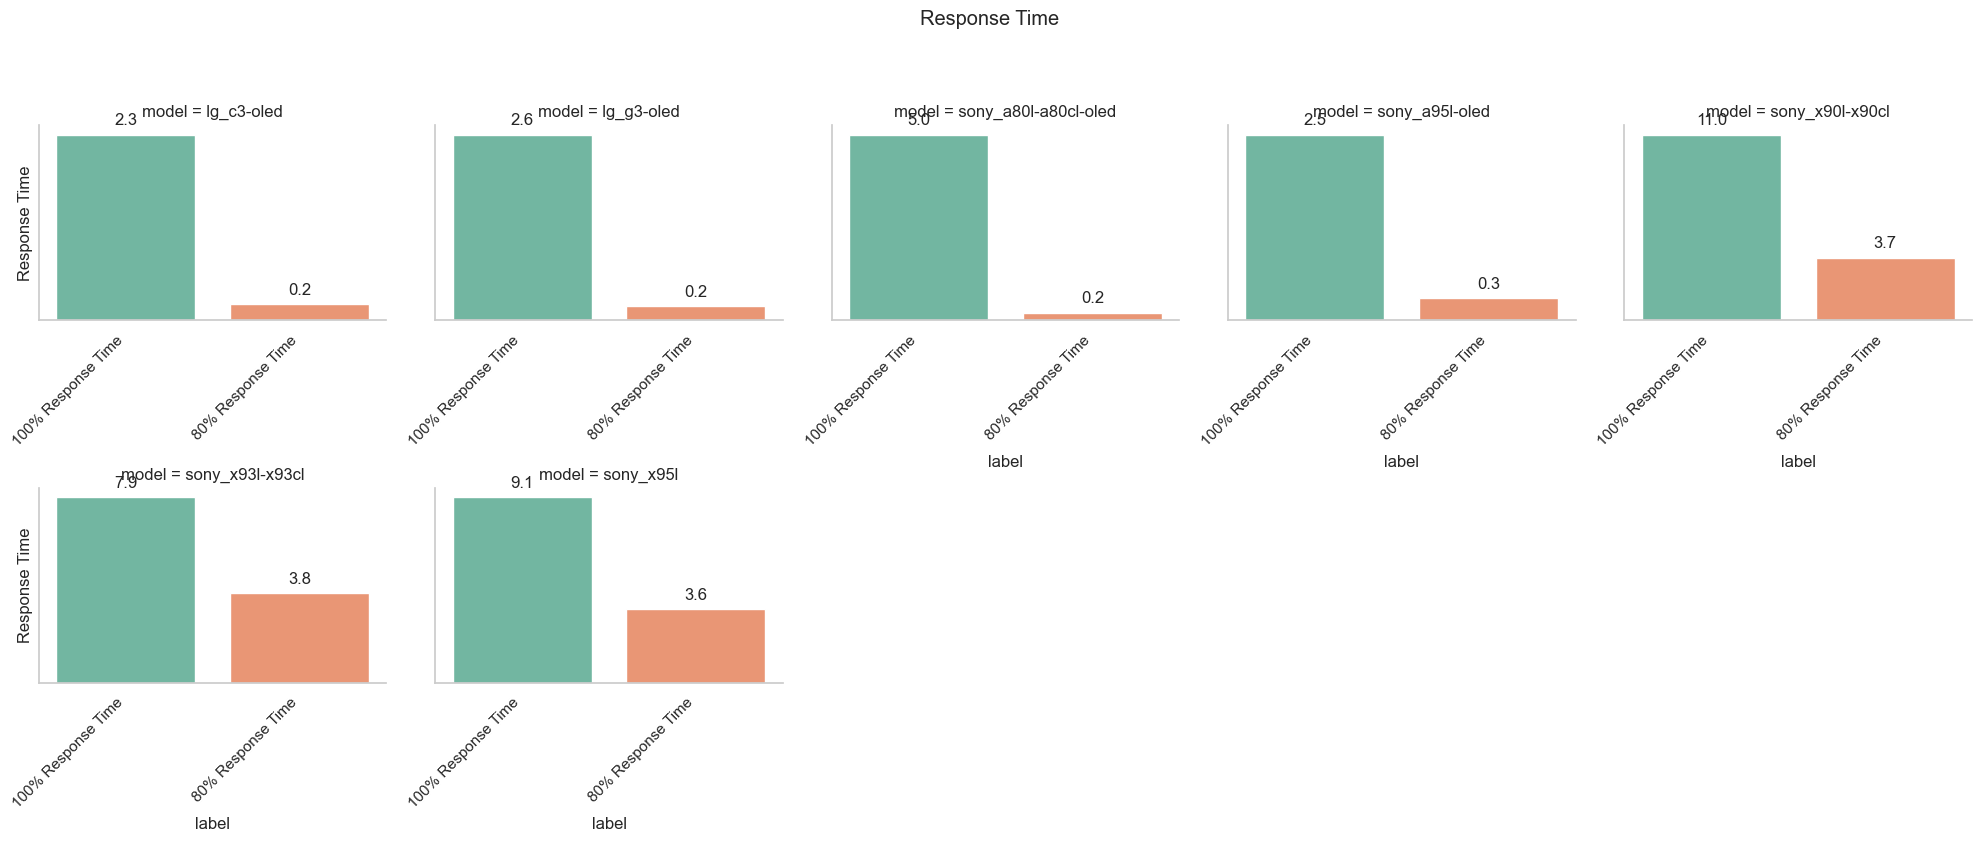

In [377]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Stutter

In [378]:
target_col =  "Stutter"
df = get_data_detail(measurement_df, target_col)

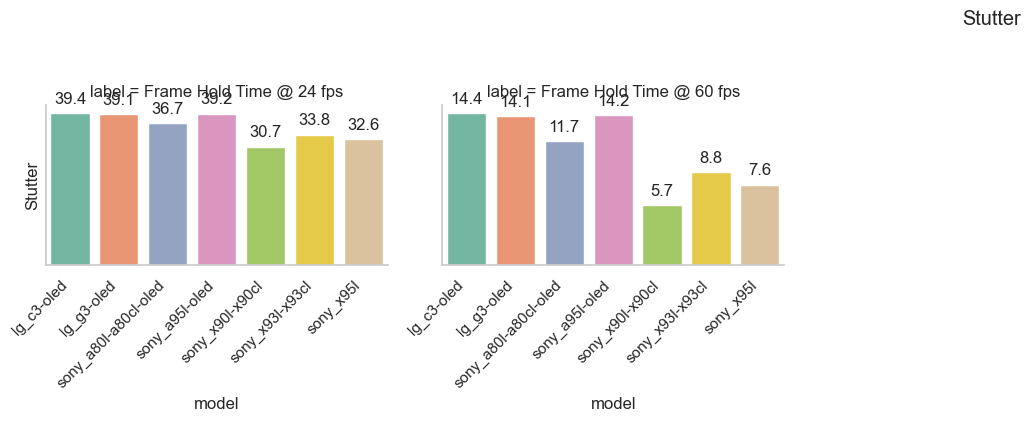

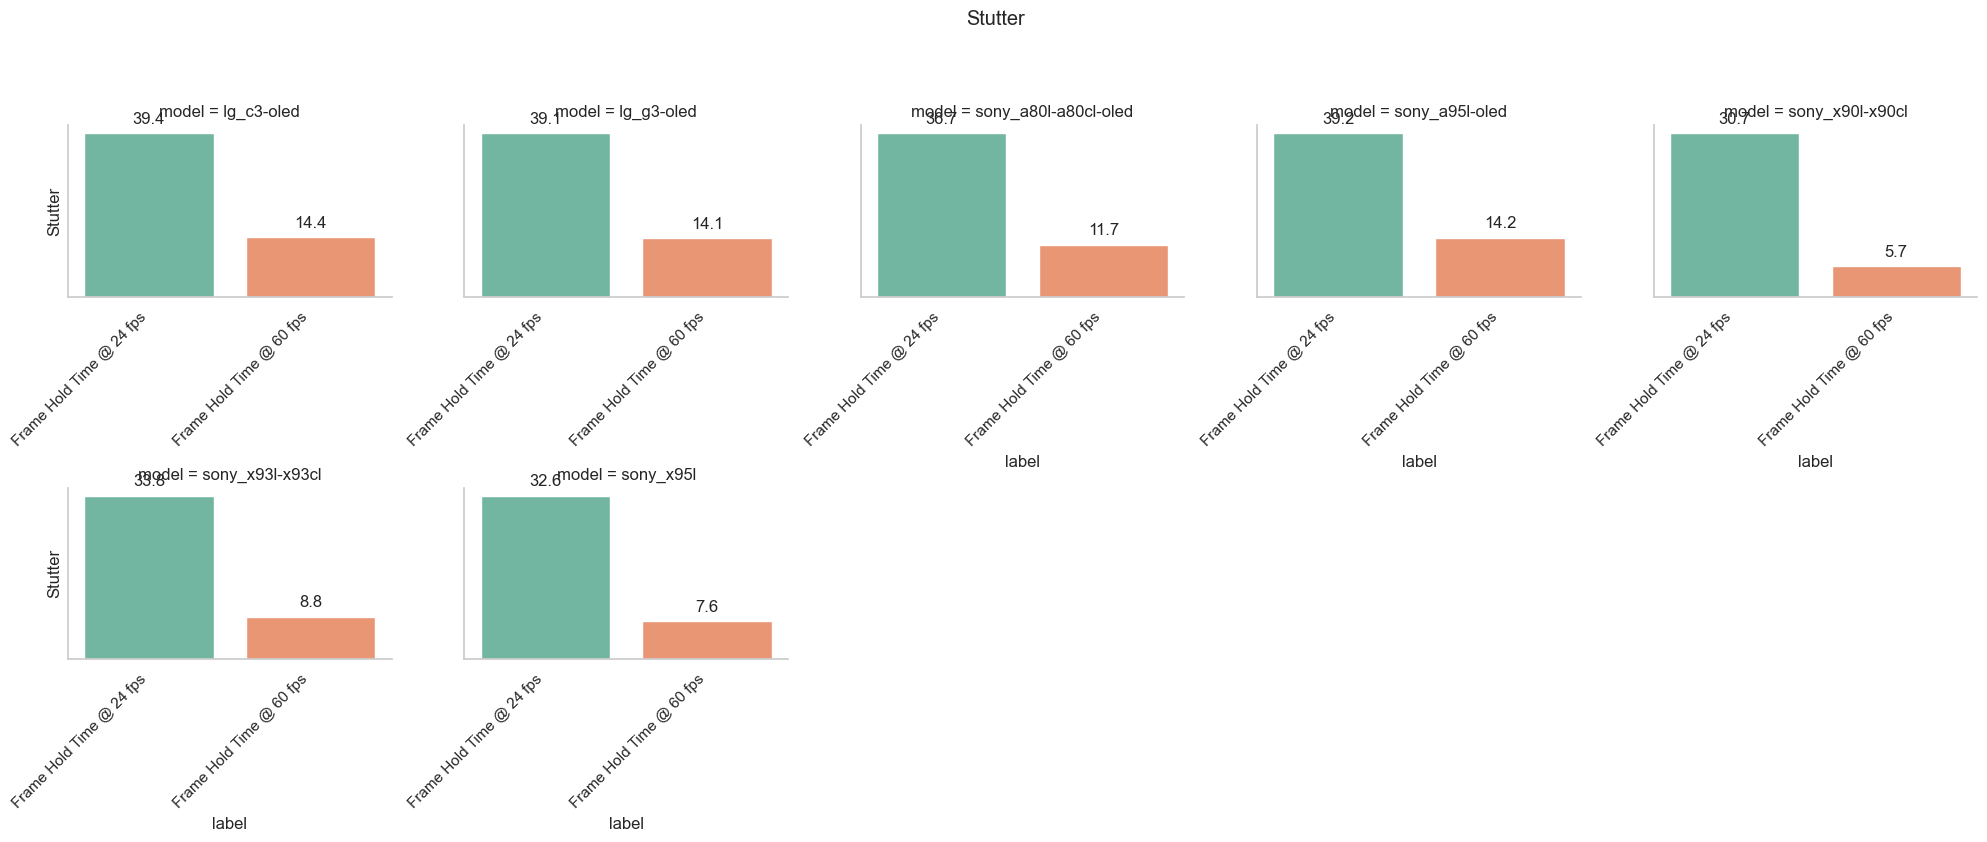

In [379]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Distortion

In [439]:
target_col =  "Distortion"
df = get_data_detail(measurement_df, target_col)

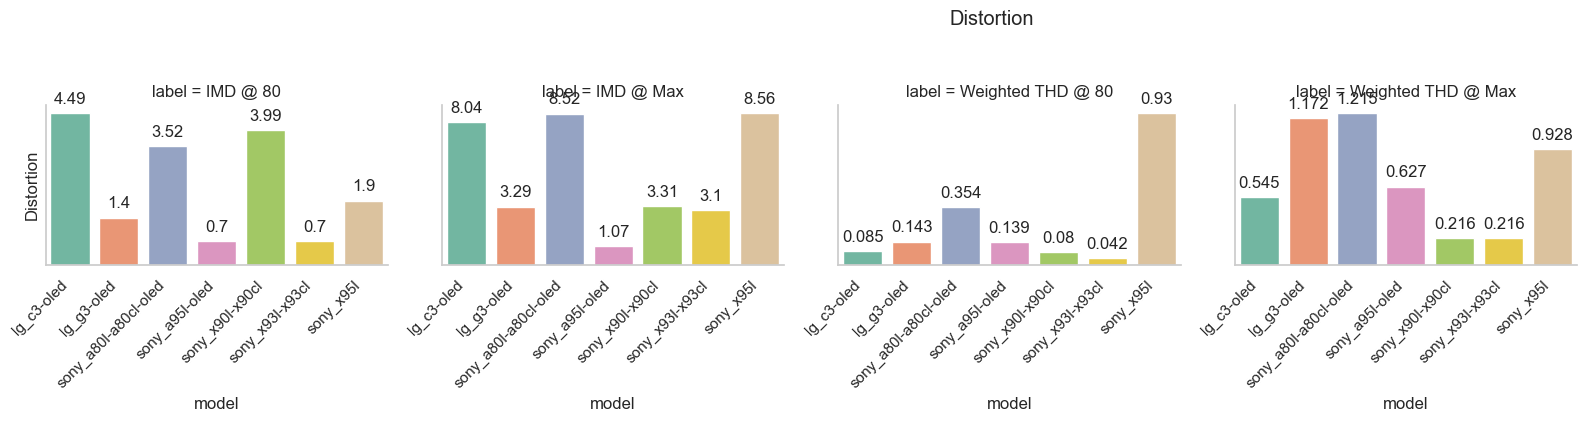

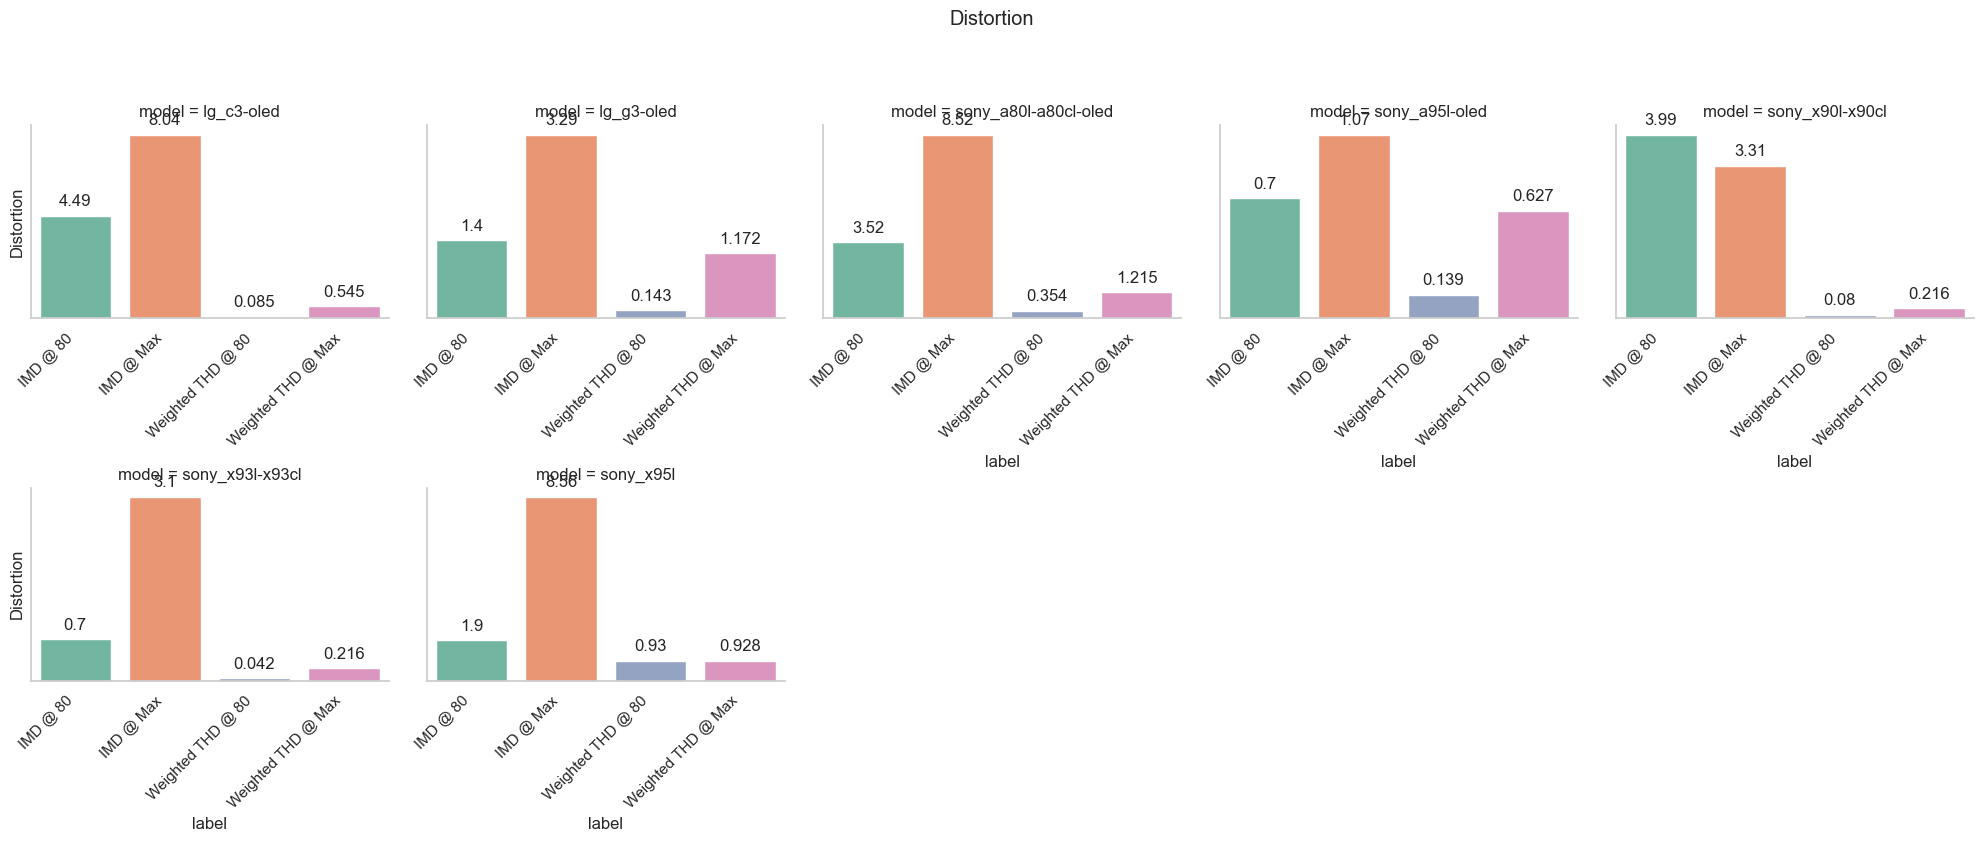

In [440]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")
plotsns_facet_bar(df, col_x="label", col_y=target_col, col_facet="model")

## Flicker-Free

In [445]:
target_col =  "Flicker-Free"
df = get_data_detail(measurement_df, target_col)

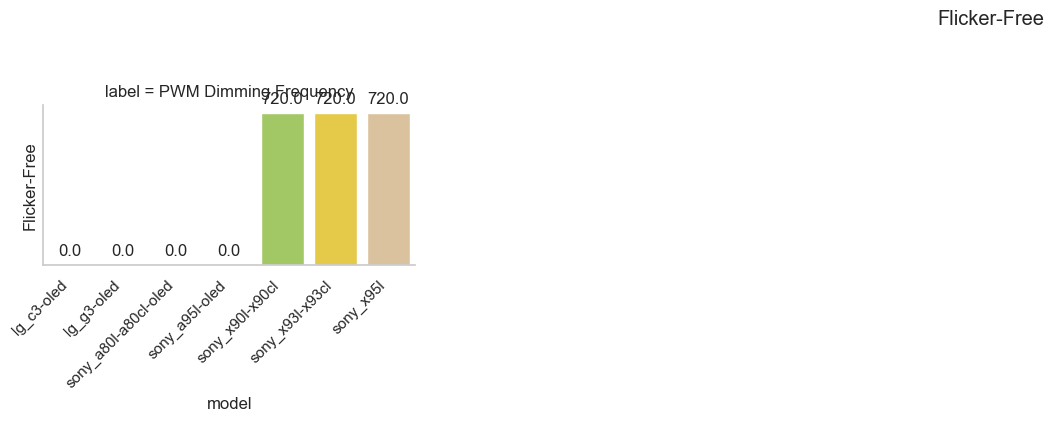

In [447]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")

## Variable Refresh Rate

In [453]:
target_col =  "Variable Refresh Rate"
df = get_data_detail(measurement_df, target_col)

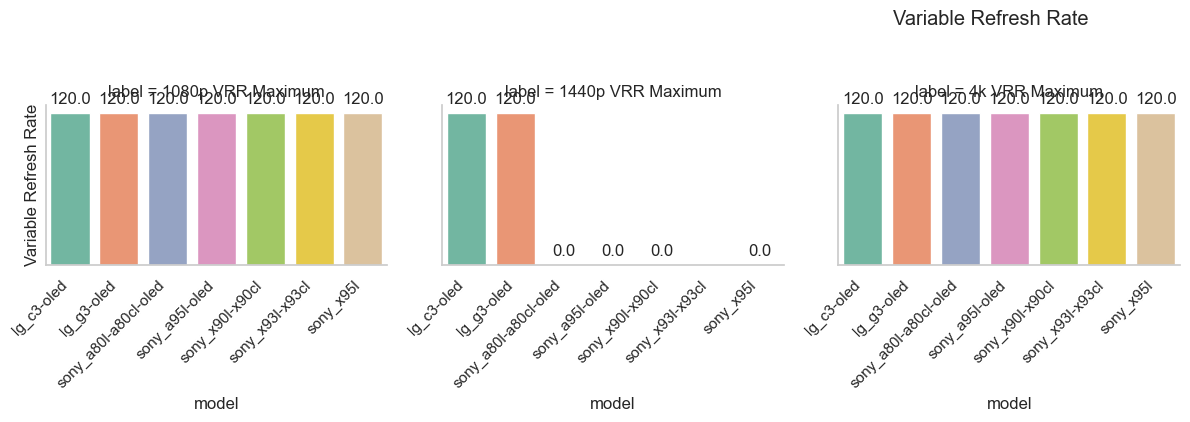

In [454]:
plotsns_facet_bar(df, col_x="model", col_y=target_col, col_facet="label")

- colab에서 파일 받기

In [ ]:
!zip -r /content/results_rtings.zip /content/results/
files.download('/content/results_rtings.zip')

---